# (FINAL) Ensemble Prophet Model + MVOP



=== Running Validation Phase ===

Validation Trade #1 at 2025-01-02 15:00:00-05:00:
Executing trades:
BTC-USD: SELL (Current: 0.20, Target: 0.20)
ETH-USD: BUY (Current: 0.20, Target: 0.20)
GOOGL-USD: SELL (Current: 0.20, Target: 0.20)
AAPL-USD: SELL (Current: 0.20, Target: 0.20)
GLD-USD: BUY (Current: 0.20, Target: 0.20)

----------------------------------------------------

Validation Trade #2 at 2025-01-03 10:00:00-05:00:
Executing trades:
BTC-USD: BUY (Current: 0.20, Target: 0.20)
ETH-USD: SELL (Current: 0.20, Target: 0.20)
GOOGL-USD: BUY (Current: 0.20, Target: 0.20)
AAPL-USD: BUY (Current: 0.20, Target: 0.20)
GLD-USD: BUY (Current: 0.20, Target: 0.20)

----------------------------------------------------

Validation Trade #3 at 2025-01-03 11:00:00-05:00:
Executing trades:
BTC-USD: SELL (Current: 0.20, Target: 0.20)
ETH-USD: SELL (Current: 0.20, Target: 0.20)
GOOGL-USD: BUY (Current: 0.20, Target: 0.20)
AAPL-USD: SELL (Current: 0.20, Target: 0.20)
GLD-USD: BUY (Current: 0.20, Targ

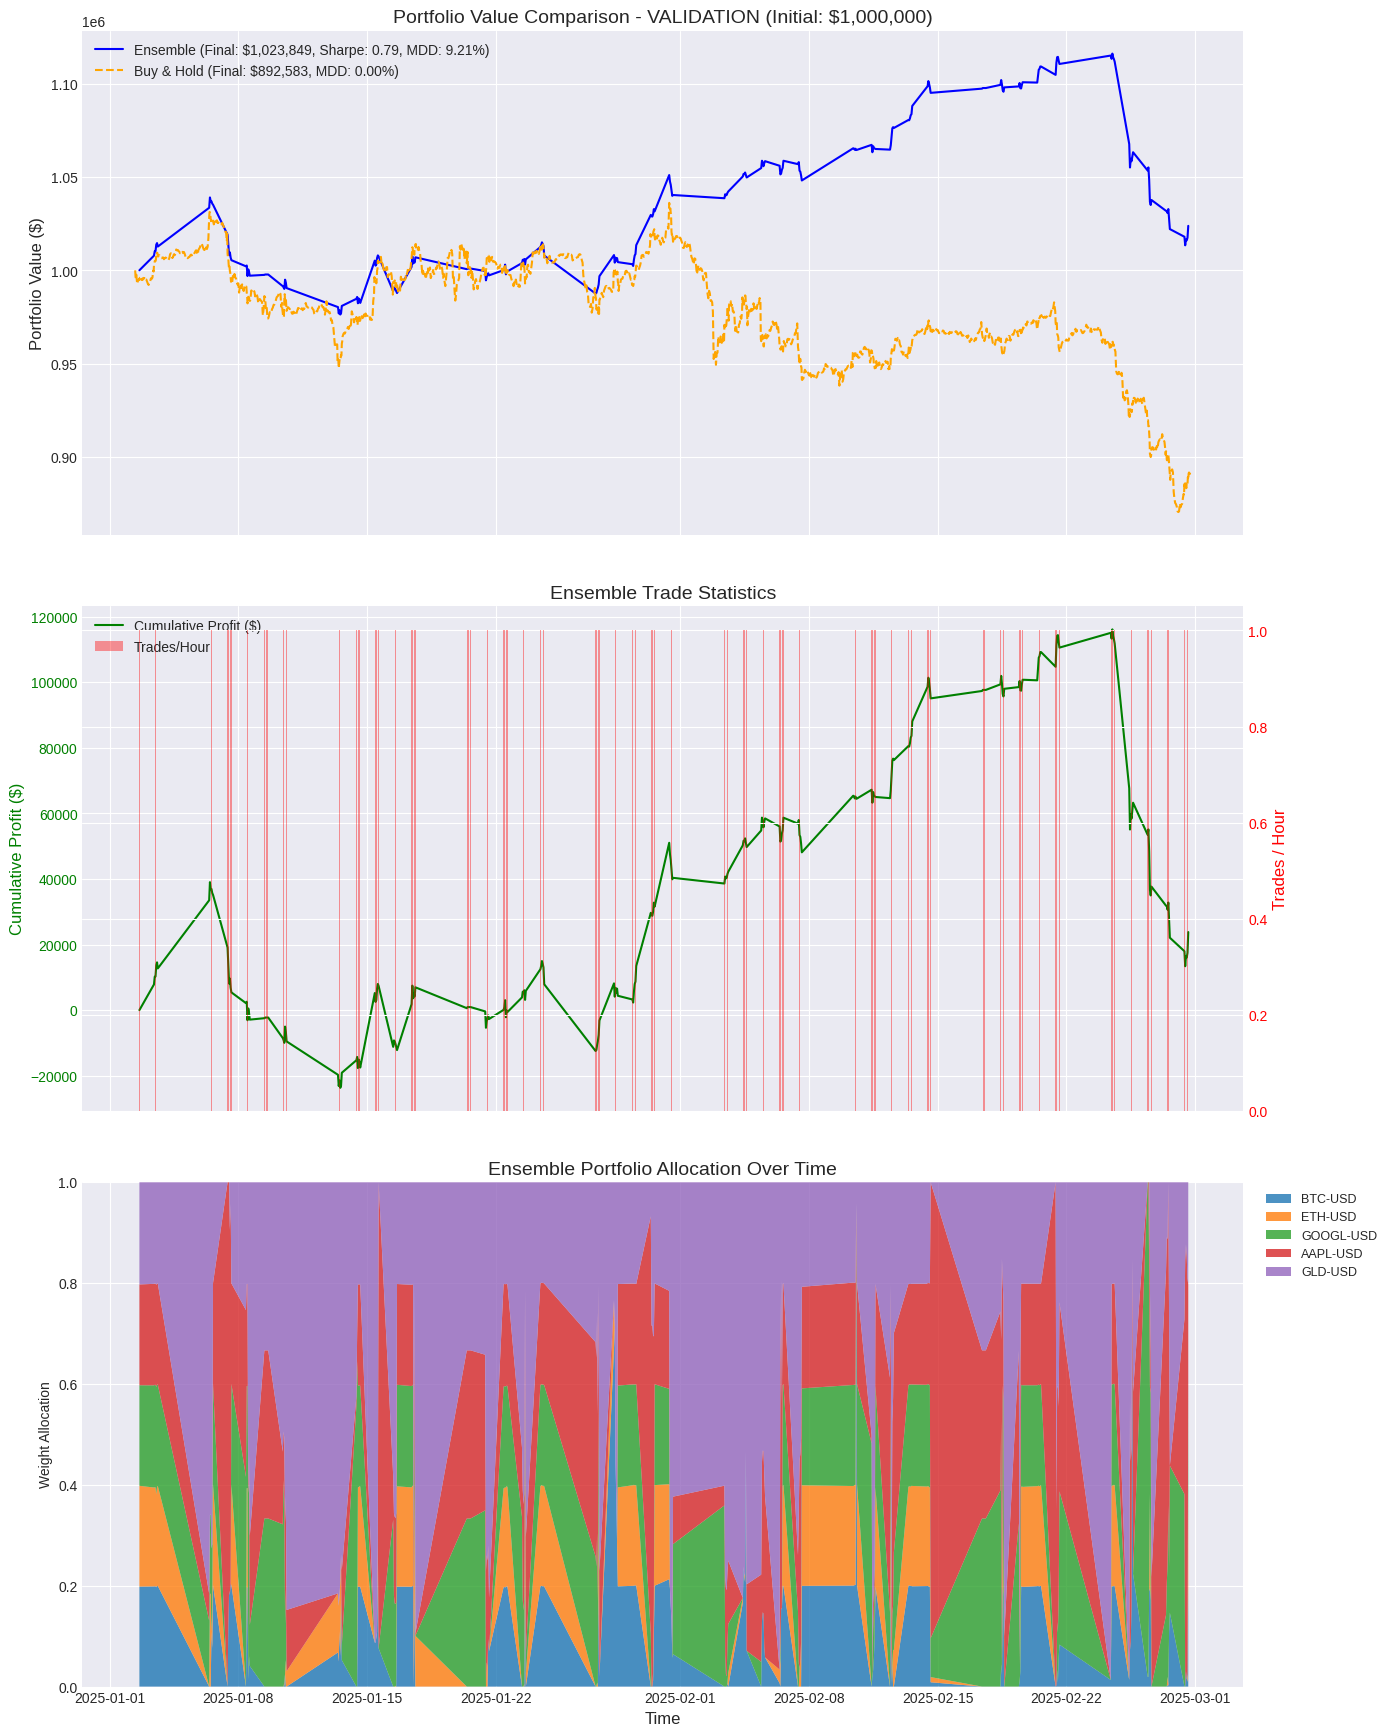


=== Running Test Phase ===

Test Trade #1 at 2025-03-03 15:00:00-05:00:
Executing trades:
BTC-USD: SELL (Current: 0.20, Target: 0.00)
ETH-USD: SELL (Current: 0.20, Target: -0.00)
GOOGL-USD: SELL (Current: 0.20, Target: 0.03)
AAPL-USD: SELL (Current: 0.20, Target: 0.00)
GLD-USD: BUY (Current: 0.20, Target: 0.96)

----------------------------------------------------

Test Trade #2 at 2025-03-04 10:00:00-05:00:
Executing trades:
BTC-USD: SELL (Current: 0.00, Target: 0.00)
ETH-USD: BUY (Current: -0.00, Target: 0.00)
GOOGL-USD: BUY (Current: 0.03, Target: 0.55)
AAPL-USD: BUY (Current: 0.00, Target: 0.42)
GLD-USD: SELL (Current: 0.96, Target: 0.03)

----------------------------------------------------

Test Trade #3 at 2025-03-04 11:00:00-05:00:
Executing trades:
BTC-USD: BUY (Current: 0.00, Target: 0.00)
ETH-USD: SELL (Current: 0.00, Target: 0.00)
GOOGL-USD: SELL (Current: 0.55, Target: -0.00)
AAPL-USD: BUY (Current: 0.42, Target: 1.00)
GLD-USD: SELL (Current: 0.03, Target: 0.00)

--------

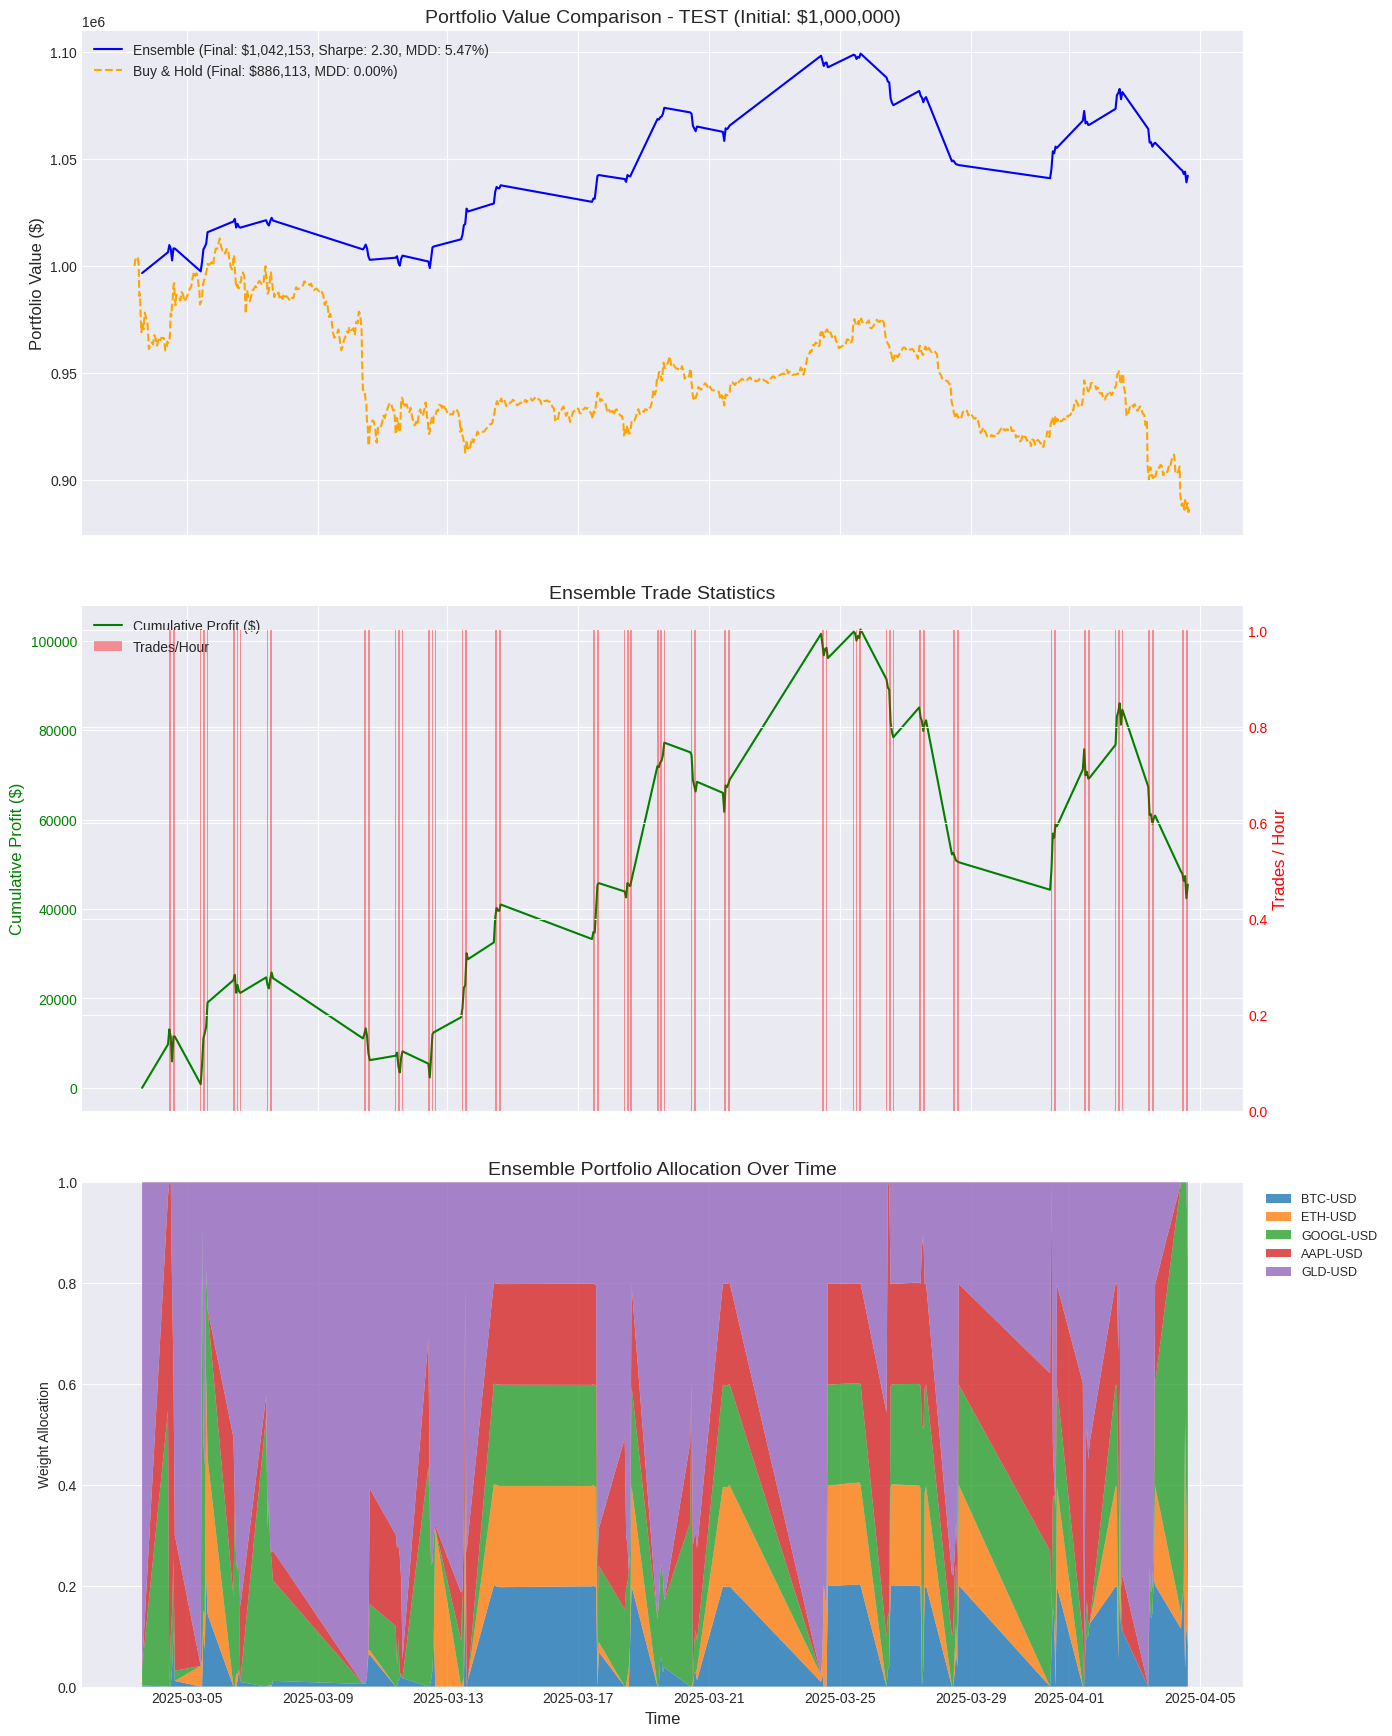

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp
import logging
from prophet import Prophet
import os
import traceback

def load_train_data(assets):
    dfs = []
    for asset in assets:
        filename = f"{asset}_hourly_train.csv"
        df = pd.read_csv(filename)
        df['date'] = pd.to_datetime(df['date'], dayfirst=True)
        df = df[['date', 'close']].rename(columns={'close': asset})
        dfs.append(df)

    merged_df = dfs[0]
    for i in range(1, len(dfs)):
        merged_df = pd.merge(merged_df, dfs[i], on='date', how='outer')

    merged_df.sort_values('date', inplace=True)
    merged_df = merged_df.ffill().dropna()
    return merged_df

def load_val_data(assets):
    dfs = []
    for asset in assets:
        filename = f"{asset}_hourly_val.csv"
        df = pd.read_csv(filename)
        df['date'] = pd.to_datetime(df['date'], dayfirst=True)
        df = df[['date', 'close']].rename(columns={'close': asset})
        dfs.append(df)

    merged_df = dfs[0]
    for i in range(1, len(dfs)):
        merged_df = pd.merge(merged_df, dfs[i], on='date', how='outer')

    merged_df.sort_values('date', inplace=True)
    merged_df = merged_df.ffill().dropna()
    return merged_df

def load_test_data(assets):
    dfs = []
    for asset in assets:
        filename = f"{asset}_hourly_test.csv"
        df = pd.read_csv(filename)
        df['date'] = pd.to_datetime(df['date'], dayfirst=True)
        df = df[['date', 'close']].rename(columns={'close': asset})
        dfs.append(df)

    merged_df = dfs[0]
    for i in range(1, len(dfs)):
        merged_df = pd.merge(merged_df, dfs[i], on='date', how='outer')

    merged_df.sort_values('date', inplace=True)
    merged_df = merged_df.ffill().dropna()
    return merged_df

# Prophet Model Setup & Training
def train_all_prophet_models(train_df, assets):
    models = {}
    historical_avgs = {}

    for asset in assets:
        df = train_df.copy().rename(columns={"date": "ds"})
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

        prophet_data = df[['ds', asset]].rename(columns={asset: 'y'})
        regressors = [a for a in assets if a != asset]

        for reg in regressors:
            prophet_data[reg] = df[reg]

        model = Prophet(
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=10,
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False,
            seasonality_mode='multiplicative'
        )

        for reg in regressors:
            model.add_regressor(reg)

        model.fit(prophet_data)
        historical_avgs[asset] = prophet_data['y'].mean()
        models[asset] = model

    return models, historical_avgs

def forecast_next_value(model, regressor_assets, latest_data, freq='1h'):
    future = model.make_future_dataframe(periods=1, freq=freq, include_history=False)
    for asset in regressor_assets:
        future[asset] = latest_data[asset]
    forecast = model.predict(future)
    return forecast['yhat'].values[0]

# MVOP Portfolio Functions

def compute_returns(price_data):
    return price_data.pct_change(1).dropna()

def compute_covariance(returns):
    return returns.cov()

def optimize_min_variance(cov_matrix):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    if w.value is None:
        raise Exception("Optimization did not converge")
    return pd.Series(w.value, index=cov_matrix.index)

def generate_signals(current_weights, target_weights, threshold=0.01):
    signals = {}
    for asset in target_weights.index:
        current_w = current_weights.get(asset, 0)
        diff = target_weights[asset] - current_w
        if diff > threshold:
            signals[asset] = 'BUY'
        elif diff < -threshold:
            signals[asset] = 'SELL'
        else:
            signals[asset] = 'HOLD'
    return signals

def compute_equal_weight_bh(df, initial_capital=1_000_000):
    assets = df.columns
    weights = {asset: 1 / len(assets) for asset in assets}

    initial_prices = df.iloc[0]
    shares_held = {asset: (initial_capital * weights[asset]) / initial_prices[asset] for asset in assets}

    portfolio_value = df.apply(lambda row: sum(shares_held[a] * row[a] for a in assets), axis=1)
    return portfolio_value

def execute_trades(signals, current_weights, target_weights):
    print("Executing trades:")
    for asset, signal in signals.items():
        print(f"{asset}: {signal} (Current: {current_weights.get(asset, 0):.2f}, Target: {target_weights[asset]:.2f})")
    print("\n----------------------------------------------------")

# Ensemble Trading Strategy

def rotating_ensemble_strategy(price_data, models, historical_avgs,
                               initial_capital=1000000, window=10,
                               threshold=0, alpha=0.001, phase=""):
    assets = price_data.columns.tolist()
    price_data.index = pd.to_datetime(price_data.index)
    price_data.index = price_data.index.tz_localize("UTC").tz_convert("US/Eastern")

    current_weights = {asset: 1/len(assets) for asset in assets}
    portfolio_value = initial_capital
    initial_prices = price_data.iloc[window-1]
    holdings = {asset: (portfolio_value * current_weights[asset]) / initial_prices[asset]
               for asset in assets}

    results = []
    trade_count = 0
    total_fees = 0

    # only trade within trading hours
    for i in range(window, len(price_data)):
        current_time = price_data.index[i]
        if current_time.weekday() >=5:
            continue
        if (current_time.hour <9 or current_time.hour >=16) or (current_time.hour ==9 and current_time.minute <30):
            continue
        if current_time.minute !=0:
            continue

        current_prices = price_data.iloc[i]
        portfolio_value = sum(holdings[a] * current_prices[a] for a in assets)

        # --- Stop Loss Mechanism
        if portfolio_value < 800000:
            print(f"\nStop loss triggered at {current_time}. Portfolio value: ${portfolio_value:,.2f}")
            fee_stop_loss = sum(holdings[a] * current_prices[a] * 0.0025 for a in assets)
            total_fees += fee_stop_loss
            portfolio_value -= fee_stop_loss

            for a in assets:
                holdings[a] = 0

            # Record the stop loss trade
            row_data = {
                'timestamp': current_time,
                'portfolio_value': portfolio_value,
                'profit': portfolio_value - (results[-1]['portfolio_value'] if results else initial_capital),
                'trade_count': 1
            }
            for asset in assets:
                row_data[f"{asset}_weight"] = 0
                row_data[f"{asset}_price"] = current_prices[asset]
                row_data[f"{asset}_signal"] = "SELL"
            results.append(row_data)
            print(f"Stop loss executed. Final portfolio value: ${portfolio_value:,.2f}")
            break

        # MVOP weights
        price_window = price_data.iloc[i-window:i]
        returns = compute_returns(price_window)
        if returns.empty: continue

        cov_matrix = compute_covariance(returns)
        mvop_weights = optimize_min_variance(cov_matrix)

        # Forecasts for all assets
        current_regressor_values = price_data.iloc[i]
        adjusted_weights = mvop_weights.copy()

        for asset in assets:
            forecast = forecast_next_value(models[asset],
                                          [a for a in assets if a != asset],
                                          current_regressor_values)

            forecast_ratio = forecast / historical_avgs[asset]
            adjusted_weights[asset] *= (1 + alpha * (forecast_ratio - 1))

        adjusted_weights = adjusted_weights / adjusted_weights.sum()

        # Generate signals
        current_port_weights = {a: (holdings[a] * current_prices[a])/portfolio_value
                               for a in assets}
        signals = generate_signals(current_port_weights, adjusted_weights, threshold)

        did_trade = any(sig in ['BUY', 'SELL'] for sig in signals.values())
        prev_value = results[-1]['portfolio_value'] if results else portfolio_value
        profit = portfolio_value - prev_value

        row_data = {
            'timestamp': current_time,
            'portfolio_value': portfolio_value,
            'profit': profit,
            'trade_count': int(did_trade)
        }

        for asset in assets:
            row_data[f"{asset}_weight"] = adjusted_weights.get(asset, np.nan)
            row_data[f"{asset}_price"] = current_prices[asset]
            row_data[f"{asset}_signal"] = signals.get(asset, "HOLD")

        results.append(row_data)

        if did_trade:
            trade_count += 1
            print(f"\n{phase.capitalize()} Trade #{trade_count} at {current_time}:")
            execute_trades(signals, current_port_weights, adjusted_weights)
            # Calculate transaction fees
            current_values = {a: holdings[a] * current_prices[a] for a in assets}
            target_values = {a: portfolio_value * adjusted_weights[a] for a in assets}
            trade_fee = sum(abs(target_values[a] - current_values[a]) * 0.00025 for a in assets)
            total_fees += trade_fee
            portfolio_value -= trade_fee

            for a in assets:
                holdings[a] = (target_values[a] / portfolio_value) * (portfolio_value + trade_fee) / current_prices[a]

    results_df = pd.DataFrame(results).set_index('timestamp', drop=True)
    final_portfolio_value = results_df['portfolio_value'].iloc[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital
    return results_df, total_return, trade_count, total_fees

# Performance Metrics

def compute_performance_metrics(results_df, trade_count, risk_free_rate=0.01, phase="test"):
    returns = results_df['portfolio_value'].pct_change().dropna()
    profit_series = results_df['portfolio_value'].diff().dropna()
    avg_profit = profit_series.mean()
    num_periods = len(results_df)
    trades_per_hour = trade_count / num_periods if num_periods > 0 else 0
    win_rate = (profit_series > 0).sum() / len(profit_series) if len(profit_series) > 0 else np.nan

    # Annual Return
    total_return = (results_df['portfolio_value'].iloc[-1] / results_df['portfolio_value'].iloc[0]) - 1
    hours_in_year = 252 * 6.5  # Trading hours per year
    annual_factor = 1638.0 / num_periods if num_periods >0 else np.nan
    annual_return = (1 + total_return) ** annual_factor - 1

    # Sharpe Ratio
    sharpe = ((returns.mean() * hours_in_year) - risk_free_rate) / (returns.std() * math.sqrt(hours_in_year)) if returns.std() != 0 else np.nan

    # Max Drawdown
    cumulative_returns = results_df['portfolio_value'] / results_df['portfolio_value'].iloc[0]
    rolling_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    # Annual Volatility
    annual_volatility = returns.std() * math.sqrt(hours_in_year)

    # Drawdown Patterns
    drawdown_patterns = ((drawdowns < 0) & (drawdowns.shift(1) == 0)).sum()

    # Number of Trades
    number_of_trades = trade_count

    # Average Holding Period
    if number_of_trades > 0:
        avg_holding_period = num_periods / number_of_trades
    else:
        avg_holding_period = np.nan

    # Profit per Trade
    profit_per_trade = profit_series.sum() / number_of_trades if number_of_trades > 0 else np.nan

    print("\n----------------------------------------------------")
    print(f"Total {phase.capitalize()} Hours: {num_periods}")
    print(f"Total {phase.capitalize()} Trades Executed: {trade_count}")
    print(f"{phase.capitalize()} Win Rate (profitable hours): {win_rate*100:.2f}%")
    print("\n----------------------------------------------------")

    return {
        "sharpe": sharpe,
        "trades_per_hour": trades_per_hour,
        "avg_profit": avg_profit,
        "win_rate": win_rate,
        "annual_return": annual_return,
        "max_drawdown": max_drawdown,
        "annual_volatility": annual_volatility,
        "drawdown_patterns": drawdown_patterns,
        "number_of_trades": number_of_trades,
        "avg_holding_period": avg_holding_period,
        "profit_per_trade": profit_per_trade
    }



def plot_ensemble_results(ensemble_df, bh_df, ensemble_metrics, initial_capital=1_000_000, dataset_name="TEST"):
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

        # Portfolio Value Comparison
        ax0 = axes[0]
        ens_mdd_pct = -ensemble_metrics.get('max_drawdown', np.nan) * 100
        ens_label = f'Ensemble (Final: ${ensemble_df["portfolio_value"].iloc[-1]:,.0f}, Sharpe: {ensemble_metrics.get("sharpe", 0):.2f}, MDD: {ens_mdd_pct:.2f}%)'
        ax0.plot(ensemble_df.index, ensemble_df['portfolio_value'], label=ens_label, color='b', linewidth=1.5)

        if bh_df is not None:
            bh_mdd_pct = ((bh_df / bh_df.iloc[0]).cummax() - (bh_df / bh_df.iloc[0])).min() * 100
            bh_label = f'Buy & Hold (Final: ${bh_df.iloc[-1]:,.0f}, MDD: {bh_mdd_pct:.2f}%)'
            ax0.plot(bh_df.index, bh_df, '--', label=bh_label, color='orange', linewidth=1.5)

        ax0.set_title(f'Portfolio Value Comparison - {dataset_name.upper()} (Initial: ${initial_capital:,.0f})', fontsize=14)
        ax0.set_ylabel("Portfolio Value ($)", fontsize=12)
        ax0.legend(fontsize=10)
        ax0.grid(True)

        # Cumulative Profit & Trade Count
        ax1 = axes[1]
        ax1b = ax1.twinx()
        cumulative_pl = ensemble_df['profit'].cumsum()
        ln1 = ax1.plot(cumulative_pl.index, cumulative_pl, label='Cumulative Profit ($)', color='g', linewidth=1.5)
        ax1.set_ylabel('Cumulative Profit ($)', color='g', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='g')

        trades = ensemble_df['trade_count']
        bar2 = ax1b.bar(trades.index, trades, label='Trades/Hour', color='r', alpha=0.4, width=0.02)
        ax1b.set_ylabel('Trades / Hour', color='r', fontsize=12)
        ax1b.tick_params(axis='y', labelcolor='r')

        lines = ln1 + [bar2]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=10)
        ax1.set_title('Ensemble Trade Statistics', fontsize=14)
        ax1.grid(True)

        # Allocation Weights Over Time
        ax2 = axes[2]
        weight_cols = [col for col in ensemble_df.columns if col.endswith('_weight')]
        if weight_cols:
            weight_df = ensemble_df[weight_cols].copy()
            weight_df = weight_df.div(weight_df.sum(axis=1), axis=0).fillna(0)
            ax2.stackplot(weight_df.index, weight_df.T.values, labels=[col.replace('_weight', '') for col in weight_cols], alpha=0.8)
            ax2.set_title("Ensemble Portfolio Allocation Over Time", fontsize=14)
            ax2.set_ylabel("Weight Allocation")
            ax2.set_ylim(0, 1)
            ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9)

        ax2.set_xlabel("Time", fontsize=12)
        ax2.grid(True)

        plt.tight_layout(pad=3.0)
        plt.subplots_adjust(right=0.85)
        plt.show()  # Changed from saving to display
    except Exception as e:
        print(f"Error while plotting ensemble results: {e}")
        traceback.print_exc()

if __name__ == "__main__":

    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
    logging.getLogger('prophet').setLevel(logging.WARNING)

    assets = ["BTC-USD", "ETH-USD", "GOOGL-USD", "AAPL-USD", "GLD-USD"]
    initial_capital = 1000000

    # Load data
    train_df = load_train_data(assets)
    val_df = load_val_data(assets).set_index("date")
    test_df = load_test_data(assets).set_index("date")

    prophet_models, historical_avgs = train_all_prophet_models(train_df, assets)

    # Validation Phase
    print("\n=== Running Validation Phase ===")
    val_results, val_return, val_trades, val_fees = rotating_ensemble_strategy(
        val_df, prophet_models, historical_avgs,
        initial_capital=initial_capital, phase="validation"
    )
    val_metrics = compute_performance_metrics(val_results, val_trades, phase="validation")

    # Validation Results
    print(f"\n[VALIDATION RESULTS]")
    print(f"Final Portfolio Value: {val_results['portfolio_value'].iloc[-1]:.2f}")
    print(f"Total Return: {val_return*100:.2f}%")
    print(f"Annualized Sharpe Ratio: {val_metrics['sharpe']:.2f}")
    print(f"Annual Return: {val_metrics['annual_return']*100:.2f}%")
    print(f"Max Drawdown: {val_metrics['max_drawdown']*100:.2f}%")
    print(f"Annual Volatility: {val_metrics['annual_volatility']*100:.2f}%")
    print(f"Drawdown Patterns: {val_metrics['drawdown_patterns']}")
    print(f"Average Trades per Hour: {val_metrics['trades_per_hour']:.2f}")
    print(f"Number of Trades: {val_metrics['number_of_trades']}")
    print(f"Average Holding Period (hrs): {val_metrics['avg_holding_period']:.2f}")
    print(f"Profit per Trade: {val_metrics['profit_per_trade']:.2f}")
    print(f"Average Profit per Hour: {val_metrics['avg_profit']:.2f}")
    print(f"Win Rate: {val_metrics['win_rate']*100:.2f}%")

    # Validation accounting
    print("\nFinal Accounting (Validation Data):")
    print(f"Initial Portfolio Value: ${initial_capital:,.2f}")
    print(f"Total Trading Fees Paid: ${val_fees:,.2f}")
    print(f"Final Portfolio Value (after deduction of trading fees): ${val_results['portfolio_value'].iloc[-1]:,.2f}")
    print("\n----------------------------------------------------")

    # Plot validation results
    bh_equal_series_val = compute_equal_weight_bh(val_df, initial_capital=initial_capital)
    plot_ensemble_results(
        ensemble_df=val_results,
        bh_df=bh_equal_series_val,
        ensemble_metrics=val_metrics,
        initial_capital=initial_capital,
        dataset_name="VALIDATION"
    )

    # Test Phase
    print("\n=== Running Test Phase ===")
    test_results, test_return, test_trades, test_fees = rotating_ensemble_strategy(
        test_df, prophet_models, historical_avgs,
        initial_capital=initial_capital, phase="test"
    )
    test_metrics = compute_performance_metrics(test_results, test_trades, phase="test")

    # Test Results (keep existing)
    print(f"\n[TEST RESULTS]")
    print(f"Final Portfolio Value: {test_results['portfolio_value'].iloc[-1]:.2f}")
    print(f"Total Return: {test_return*100:.2f}%")
    print(f"Annualized Sharpe Ratio: {test_metrics['sharpe']:.2f}")
    print(f"Annual Return: {test_metrics['annual_return']*100:.2f}%")
    print(f"Max Drawdown: {test_metrics['max_drawdown']*100:.2f}%")
    print(f"Annual Volatility: {test_metrics['annual_volatility']*100:.2f}%")
    print(f"Drawdown Patterns: {test_metrics['drawdown_patterns']}")
    print(f"Average Trades per Hour: {test_metrics['trades_per_hour']:.2f}")
    print(f"Number of Trades: {test_metrics['number_of_trades']}")
    print(f"Average Holding Period (hrs): {test_metrics['avg_holding_period']:.2f}")
    print(f"Profit per Trade: {test_metrics['profit_per_trade']:.2f}")
    print(f"Average Profit per Hour: {test_metrics['avg_profit']:.2f}")
    print(f"Win Rate: {test_metrics['win_rate']*100:.2f}%")
    print("\n----------------------------------------------------")

    print("\nFinal Accounting (Test Data):")
    print(f"Initial Portfolio Value: ${initial_capital:,.2f}")
    print(f"Total Trading Fees Paid: ${test_fees:,.2f}")
    print(f"Final Portfolio Value (after deduction of trading fees): ${test_results['portfolio_value'].iloc[-1]:,.2f}")
    print("\n----------------------------------------------------------------- END -----------------------------------------------------------------\n")

    # Plot test results
    bh_equal_series_test = compute_equal_weight_bh(test_df, initial_capital=initial_capital)
    plot_ensemble_results(
        ensemble_df=test_results,
        bh_df=bh_equal_series_test,
        ensemble_metrics=test_metrics,
        initial_capital=initial_capital,
        dataset_name="TEST"
    )

# (Other Strategies Considered) Reinforcement Learning

In [ ]:
!pip install 'gymnasium>=0.29.1'
!pip install 'shimmy>=2.0.0'
!pip install stable-baselines3 gym numpy ta optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
import traceback
import pickle
from typing import Optional, Tuple, Dict, Any
from ta import add_all_ta_features

from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import optuna
import functools

CONFIG = {
    "TICKERS": ['GOOGL-USD', 'AAPL-USD', 'GLD-USD','BTC-USD', 'ETH-USD'],
    "INITIAL_BALANCE": 1000000,
    "LOOKBACK_WINDOW": 24,

    "DATA_SUFFIX_TRAIN": "train",
    "DATA_SUFFIX_VALIDATE": "val",
    "DATA_SUFFIX_TEST": "test",

    "TRAIN_DATA_PATH": "stock_data_hourly/combined_data_indexed_train.csv",
    "VAL_DATA_PATH": "stock_data_hourly/combined_data_indexed_val.csv",
    "TEST_DATA_PATH": "stock_data_hourly/combined_data_indexed_test.csv",

    "MODEL_SAVE_DIR": "trained_models_hourly_tuned/",
    "EVAL_OUTPUT_DIR": "evaluation_results_hourly_tuned/",
    "BEST_MODEL_NAME": "best_portfolio_optimizer_hourly_tuned",
    "SCALER_FILENAME": "feature_scaler_tuned.pkl",

    "WEIGHTS_FILENAME_BASE": "weights_hourly_eval",
    "PORTFOLIO_VALUE_FILENAME_BASE": "calculated_portfolio_value_scaled_hourly_eval",
    "BUY_HOLD_VALUE_FILENAME_BASE": "calculated_buy_and_hold_value_actual_hourly_eval",
    "TRADE_STATS_FILENAME_BASE": "trade_statistics_hourly_eval",
    "PLOT_FILENAME_BASE": "portfolio_comparison_scaled_plot_hourly_eval",

    "TENSORBOARD_LOG": "./ppo_portfolio_tensorboard_hourly_tuned/",

    "REWARD_LAMBDA": 0.1,
    "TRANSACTION_COST_PCT": 0.025,
    "REWARD_CLIP_MIN": -1.0,
    "REWARD_CLIP_MAX": 1.0,
    "VOLATILITY_WINDOW": 24,
    "RISK_FREE_RATE": 0.0,
    "PERIODS_PER_YEAR": 6.5 * 252,
    "TRADE_THRESHOLD": 0,

    "PPO_LEARNING_RATE": 1e-4,
    "PPO_N_STEPS": 2048,
    "PPO_BATCH_SIZE": 64,
    "PPO_N_EPOCHS": 10,
    "PPO_GAMMA": 0.99,
    "PPO_GAE_LAMBDA": 0.95,
    "PPO_CLIP_RANGE": 0.2,
    "PPO_ENT_COEF": 0.005,
    "PPO_VF_COEF": 0.5,
    "PPO_MAX_GRAD_NORM": 0.5,
    "POLICY_KWARGS": dict(net_arch=dict(pi=[128, 128], vf=[128, 128])),

    # Final training params
    "TOTAL_TIMESTEPS": 200000,
    "EVAL_FREQ": 4096,
    "N_EVAL_EPISODES": 1,

    "OPTUNA_N_TRIALS": 1,
    "OPTUNA_TRIAL_TIMESTEPS": 50000
}

# Create directory for saving models if it doesn't exist
os.makedirs(CONFIG["MODEL_SAVE_DIR"], exist_ok=True)
os.makedirs(CONFIG["EVAL_OUTPUT_DIR"], exist_ok=True)


def convert_columns_to_lowercase(df: pd.DataFrame, inplace: bool = False) -> Optional[pd.DataFrame]:
    """ Converts all column names in a pandas DataFrame to lowercase. """
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f"Input must be a pandas DataFrame, but got {type(df)}")
    new_columns = [str(col).lower() for col in df.columns]
    if inplace:
        df.columns = new_columns
        return None
    else:
        df_copy = df.copy()
        df_copy.columns = new_columns
        return df_copy

def save_scaler(scaler, config):
    """Save the feature scaler."""
    scaler_path = os.path.join(config["MODEL_SAVE_DIR"], config["SCALER_FILENAME"])
    os.makedirs(os.path.dirname(scaler_path), exist_ok=True)

    with open(scaler_path, 'wb') as f: pickle.dump(scaler, f)
    print(f"--- Saved feature scaler to {scaler_path} ---")


def load_scaler(config):
    """Load the feature scaler."""
    scaler_path = os.path.join(config["MODEL_SAVE_DIR"], config["SCALER_FILENAME"])

    with open(scaler_path, 'rb') as f:
      scaler = pickle.load(f)
    print(f"--- Loaded feature scaler from {scaler_path} ---")
    return scaler

# ==========================================
# 1. DATA FETCHING (from individual files)
# ==========================================
def fetch_data(config, suffix):
    """
    Fetch HOURLY data from individual ticker CSVs, add TA and Log Returns.
    Saves the combined result. Handles reindexing and potential data loss.
    """
    tickers = config.get("TICKERS", [])
    dfs = []
    if not tickers:
        raise ValueError("Tickers list cannot be empty in config")

    target_index = None
    processed_tickers_successfully = []


    for ticker in tickers:
        try:
            # Construct filename
            base_data_dir = os.path.dirname(config.get(f"{suffix.upper()}_DATA_PATH", f"./stock_data_hourly/combined_data_indexed_{suffix}.csv"))
            individual_file_path = os.path.join(base_data_dir, f"{ticker}_hourly_{suffix}.csv")

            print(f"    Attempting to load: {individual_file_path}")
            if not os.path.exists(individual_file_path):
                print(f"    Warning: File not found: {individual_file_path}. Trying without base dir...")
                individual_file_path = f"{ticker}_hourly_{suffix}.csv"
                if not os.path.exists(individual_file_path):
                     print(f"    ERROR: Individual file not found for {ticker}. Skipping ticker.")
                     continue

            df = pd.read_csv(individual_file_path)

            # Date Handling
            potential_date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
            this_ticker_date_col = next((col for col in ['datetime', 'date', 'timestamp', 'time'] if col in map(str.lower, potential_date_cols)), potential_date_cols[0])
            actual_date_col = next((col for col in df.columns if col.lower() == this_ticker_date_col.lower()), None)
            df[actual_date_col] = pd.to_datetime(df[actual_date_col], errors='coerce')
            initial_rows = len(df)
            df.dropna(subset=[actual_date_col], inplace=True)

            # Convert columns to lower case
            df = convert_columns_to_lowercase(df, inplace=False)
            date_col_lower = actual_date_col.lower()

            # Set index
            df = df.set_index(date_col_lower, drop=True)
            df = df.sort_index()
            print(f"    Index set to '{date_col_lower}', shape after sort: {df.shape}")

            # Reindex BTC and ETH
            if target_index is None:
                target_index = df.index
            else:
                # Reindex subsequent dataframes to the target index
                original_cols = set(df.columns)
                df = df.reindex(target_index, method='ffill')
                print(f"    Shape after reindex: {df.shape}")
                nan_counts_after_reindex = df.isnull().sum()
                print(f"    NaN counts after reindex (Top 5):\n{nan_counts_after_reindex.sort_values(ascending=False).head()}")
                current_cols = set(df.columns)

            initial_rows = len(df)
            df = df[~df.index.duplicated(keep='first')]

            # Rename volume
            volume_col_found = False
            potential_volume_cols = ['Volume USD', 'volume']
            for vol_col in potential_volume_cols:
                if vol_col in df.columns:
                    if vol_col != 'volume': df.rename(columns={vol_col: 'volume'}, inplace=True)
                    volume_col_found = True
                    break
            if not volume_col_found:
                if 'volume' not in df.columns:
                    print(f"Volume not found {ticker}")
                    df['volume'] = 0.0
                else:
                     volume_col_found = True
            # Ensure volume is numeric
            if 'volume' in df.columns:
                df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0)


            # Add TA features
            required_ta_cols = ['open', 'high', 'low', 'close', 'volume']
            missing_base_cols = [col for col in required_ta_cols if col not in df.columns]

            if not missing_base_cols:
                  lookback_buffer = config.get("TA_LOOKBACK_BUFFER", 30) + 1
                  for col in required_ta_cols:
                      if col in df.columns:
                            df[col] = pd.to_numeric(df[col], errors='coerce')
                  rows_before_dropna_ta = len(df)
                  df.dropna(subset=required_ta_cols, inplace=True)
                  rows_after_dropna_ta = len(df)
                  if rows_after_dropna_ta < rows_before_dropna_ta:
                        print(f"    Removed {rows_before_dropna_ta - rows_after_dropna_ta} rows with NaNs in required TA columns.")

                  if len(df) > lookback_buffer:
                        try:
                            df = add_all_ta_features(
                                df, open="open", high="high", low="low",
                                close="close", volume="volume", fillna=True # Fill NaNs generated by TA
                            )
                            print(f"    TA features added. Shape after TA: {df.shape}")
                        except Exception as ta_error:
                            print(f"    ERROR adding TA features for {ticker}: {ta_error}. Proceeding without TA.")
                            df = df[[col for col in required_ta_cols if col in df.columns]].copy()
                            traceback.print_exc()

            else:
                 print(f"Missing base columns {missing_base_cols} for TA for {ticker}. Skipping TA.")

            # Calculate Log returns
            close_col = 'close'
            logret_col = 'logret'

            if close_col in df.columns:
                print(f"    Attempting to calculate log returns for {ticker}...")
                df[close_col] = pd.to_numeric(df[close_col], errors='coerce')
                rows_before_dropna_logret = len(df)
                df.dropna(subset=[close_col], inplace=True)
                rows_after_dropna_logret = len(df)
                if rows_after_dropna_logret < rows_before_dropna_logret:
                     print(f"    Removed {rows_before_dropna_logret - rows_after_dropna_logret} rows with NaN 'close' price.")


                df[close_col] = df[close_col].clip(lower=1e-9)

                if len(df) > 1:
                    df[logret_col] = np.log(df[close_col] / df[close_col].shift(1))
                    df.replace([np.inf, -np.inf], np.nan, inplace=True)
                    df[logret_col].fillna(0, inplace=True)
                    print(f"    Log returns calculated. Shape after logret: {df.shape}")
                else:
                    print(f"    Warning: Not enough data ({len(df)} rows) after cleaning to calculate log returns. Setting '{logret_col}' to 0.")
                    df[logret_col] = 0.0
            else:
                print(f"    Warning: '{close_col}' column not found for {ticker}. Cannot calculate log returns.")
                df[logret_col] = 0.0

            print(f"    Adding prefix '{ticker}_' to {len(df.columns)} columns.")
            df = df.add_prefix(f"{ticker}_")
            dfs.append(df)
            processed_tickers_successfully.append(ticker)


        except Exception as e:
            print(f"Error processing {ticker} ({suffix}) {e}!!!")
            traceback.print_exc()
            continue

    print(f"Successfully processed data for tickers: {processed_tickers_successfully}")

    combined = pd.concat(dfs, axis=1)
    if not combined.index.equals(target_index.intersection(combined.index)):
         combined = combined.reindex(target_index.intersection(combined.index))

    combined = combined.sort_index()

    print("    Forward/Backward filling critical price columns...")
    critical_cols_to_fill = [f"{ticker}_close" for ticker in processed_tickers_successfully if f"{ticker}_close" in combined.columns]

    if not critical_cols_to_fill:
         print("    Warning: No '_close' columns found among successfully processed tickers. Skipping fill.")
    else:
        print(f"    Identified critical columns for filling: {critical_cols_to_fill}")
        combined[critical_cols_to_fill] = combined[critical_cols_to_fill].ffill().bfill()

    valid_indices = combined.index
    for ticker in processed_tickers_successfully:
        crit_col = f"{ticker}_close"
        if crit_col in combined.columns:
            current_valid = combined[crit_col].dropna().index
            original_len = len(valid_indices)
            valid_indices = valid_indices.intersection(current_valid)
        else:
             print(f"    INTERNAL WARNING: Critical column {crit_col} missing for {ticker}.")

    combined = combined.loc[valid_indices]
    combined = combined.ffill().bfill()


    data_path_key = f"{suffix.upper()}_DATA_PATH"
    combined_output_path = config.get(data_path_key)
    if not combined_output_path:
         raise KeyError(f"Configuration missing key for data path: {data_path_key}")

    output_dir = os.path.dirname(combined_output_path)
    if output_dir and not os.path.exists(output_dir):
        print(f"Creating output directory: {output_dir}")
        os.makedirs(output_dir, exist_ok=True)


    combined.to_csv(combined_output_path, index=True)
    print(f"    Combined data generated and saved successfully to {combined_output_path}")

    return combined


# ==========================================
# 2. DATA LOADING (Combined File)
# ==========================================
def get_or_create_combined_data(config, suffix):
    """Loads combined data if it exists, otherwise calls fetch_data."""
    data_path_key = f"{suffix.upper()}_DATA_PATH"
    combined_data_path = config[data_path_key]

    print(f"\n--- Accessing Data ({suffix}) ---")
    if os.path.exists(combined_data_path):
        print(f"Loading existing combined data from: {combined_data_path}")
        try:
            data = pd.read_csv(combined_data_path, index_col=0, parse_dates=True, low_memory=False)
            if not isinstance(data.index, pd.DatetimeIndex):
                 data.index = pd.to_datetime(data.index, errors='coerce')
                 data.dropna(axis=0, subset=[data.index.name], inplace=True)

            if data.index.tz is not None:
                data.index = data.index.tz_localize(None)
            return data
        except Exception as e:
            print(f"Error loading data from {combined_data_path}: {e}")
    else:
        print(f"Combined data file not found: {combined_data_path}")
        print("Attempting to generate data from individual ticker CSVs...")


    generated_data = fetch_data(config, suffix)
    if generated_data.index.tz is not None:
          generated_data.index = generated_data.index.tz_localize(None)
    return generated_data


# ==========================================
# 3. DATA PREPARATION (Scaling, Feature Selection)
# ==========================================
def prepare_data(combined_data, config, scaler=None):
    """Feature selection, scaling, and separation of unscaled prices."""
    print("\n--- Preparing Data Features & Prices ---")
    tickers = config["TICKERS"]
    features_to_select = []
    unscaled_price_cols = []

    # Define potential base features to look for after TA
    base_feature_names = ["logret", "volume",
                          "volatility_bbh", "volatility_bbl", "volatility_bbw", "volatility_kch", "volatility_kcl", "volatility_dch", "volatility_dcl",
                          "trend_macd", "trend_macd_signal", "trend_macd_diff", "trend_sma_fast", "trend_ema_fast", "trend_adx", "trend_adx_pos", "trend_adx_neg",
                          "momentum_rsi", "momentum_stoch_rsi", "momentum_stoch_rsi_k", "momentum_stoch_rsi_d", "momentum_tsi", "momentum_uo", "momentum_stoch", "momentum_stoch_signal", "momentum_ao"]

    for ticker in tickers:
        ticker_prefix = f"{ticker}_"
        for base_name in base_feature_names:
             feature_name = f"{ticker_prefix}{base_name}"
             if feature_name in combined_data.columns:
                 features_to_select.append(feature_name)

        price_col = f"{ticker_prefix}close"
        if price_col in combined_data.columns:
            unscaled_price_cols.append(price_col)
        else:
             raise ValueError(f"Missing critical price column: {price_col}")

    if not features_to_select:
         raise ValueError("No features were selected. Check TA generation and column names.")
    if len(unscaled_price_cols) != len(tickers):
         print(f"    Warning: Mismatch between price columns ({len(unscaled_price_cols)}) and tickers ({len(tickers)}).")

    available_features = features_to_select
    feature_data = combined_data[available_features].copy()
    unscaled_price_data = combined_data[unscaled_price_cols].copy()

    # Change Null and Infinite to 0
    feature_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    if feature_data.isnull().values.any():
        print(f"    Warning: NaNs found in {feature_data.isnull().sum().sum()} cells of feature data before scaling. Filling with 0.")
        feature_data.fillna(0, inplace=True)

    if unscaled_price_data.isnull().values.any() or \
       np.isinf(unscaled_price_data.values).any() or \
       (unscaled_price_data <= 0).any().any():
        unscaled_price_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        unscaled_price_data.clip(lower=1e-9, inplace=True)
        unscaled_price_data.ffill(inplace=True)
        unscaled_price_data.bfill(inplace=True)

    # Scaling
    if scaler is None:
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(feature_data)
    else:
        print("Using saved StandardScaler.")
        try:
            scaled_values = scaler.transform(feature_data)
        except Exception as e:
            print(f"    Unexpected error applying scaler: {e}")
            return None, None, None

    scaled_features_df = pd.DataFrame(scaled_values, columns=feature_data.columns, index=feature_data.index)

    return scaled_features_df, unscaled_price_data, scaler


# ==========================================
# 4. RL Environment Class (Gymnasium API)
# ==========================================
class PortfolioEnv(gym.Env):
    """Custom Environment for portfolio optimization using Gymnasium API."""
    metadata = {'render_modes': ['human']}

    def __init__(self, scaled_features_df, unscaled_prices_df, config):
        super().__init__()
        self.config = config
        self.scaled_features_df = scaled_features_df
        self.unscaled_prices_df = unscaled_prices_df
        self.tickers = config["TICKERS"]
        self.n_assets = len(self.tickers)
        self.lookback = config["LOOKBACK_WINDOW"]

        # Input Validation
        if not scaled_features_df.index.equals(unscaled_prices_df.index):
            common_index = scaled_features_df.index.intersection(unscaled_prices_df.index)
            if common_index.empty:
                 raise ValueError("Indices of scaled_features_df and unscaled_prices_df have no overlap!")
            self.scaled_features_df = scaled_features_df.loc[common_index]
            self.unscaled_prices_df = unscaled_prices_df.loc[common_index]


        self.df_index = self.scaled_features_df.index
        self.total_steps = len(self.df_index)

        self.initial_balance = config["INITIAL_BALANCE"]
        self.reward_lambda = config["REWARD_LAMBDA"]
        self.transaction_cost_pct = config["TRANSACTION_COST_PCT"]
        self.volatility_window = config["VOLATILITY_WINDOW"]


        self.action_space = spaces.Box(low=-5, high=5, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.scaled_features_df.shape[1]), dtype=np.float32)



        self.current_step = 0; self.portfolio_value = 0.0
        self.weights = np.zeros(self.n_assets, dtype=np.float32)
        self.portfolio_value_history = []
        self.weights_history = []; self.portfolio_return_history = []

    def reset(self, seed=None, options=None):
        """ Resets the environment to the start of a new episode. """
        super().reset(seed=seed)
        self.current_step = self.lookback
        self.portfolio_value = self.initial_balance
        self.weights = np.full(self.n_assets, 1.0 / self.n_assets, dtype=np.float32)
        self.portfolio_value_history = [self.initial_balance] * self.lookback
        self.weights_history = [self.weights.copy()] * self.lookback
        self.portfolio_return_history = [0.0] * self.lookback
        observation = self._get_observation()
        info = self._get_info()
        return observation, info

    def step(self, action):
        """ Executes one time step within the environment based on the agent's action. """
        current_data_idx=self.current_step
        terminated = current_data_idx >= self.total_steps - 1
        truncated=False
        if terminated:
            return self._get_observation(), 0.0, terminated, truncated, self._get_info()

        # Store state before taking the step
        previous_weights = self.weights.copy()
        previous_portfolio_value = self.portfolio_value

        # Convert the agent's raw action into a valid portfolio weight distribution
        self.weights = self._apply_softmax_normalization(action)
        current_prices = self.unscaled_prices_df.iloc[current_data_idx].values
        next_prices = self.unscaled_prices_df.iloc[current_data_idx + 1].values
        current_prices = np.maximum(current_prices, 1e-9)
        next_prices = np.maximum(next_prices, 1e-9)
        asset_simple_returns = (next_prices / current_prices) - 1

        # Calculate overall portfolio simple return based on weights before action was applied
        portfolio_simple_return = np.sum(previous_weights * asset_simple_returns)

        # Calculate total change in weights
        turnover = np.sum(np.abs(self.weights - previous_weights))
        transaction_costs = self.transaction_cost_pct * turnover

        # Calculate the net return after deducting transaction costs
        net_portfolio_simple_return = portfolio_simple_return - transaction_costs
        self.portfolio_value = previous_portfolio_value * (1 + net_portfolio_simple_return)
        self.portfolio_value = max(self.portfolio_value, 1e-6)
        portfolio_log_return=np.log(1 + net_portfolio_simple_return) if (1 + net_portfolio_simple_return) > 0 else -np.inf
        if np.isinf(portfolio_log_return):
             portfolio_log_return = self.config["REWARD_CLIP_MIN"]
        self.portfolio_return_history.append(portfolio_log_return)
        reward_volatility_penalty = 0.

        # Calculate volatility penalty if enough history exists
        if len(self.portfolio_return_history) >= self.volatility_window:
            rolling_returns = self.portfolio_return_history[-self.volatility_window:]
            rolling_std_dev=np.std(rolling_returns)
            if rolling_std_dev > 1e-9:
              reward_volatility_penalty = self.reward_lambda * rolling_std_dev

        reward = portfolio_log_return - reward_volatility_penalty
        reward = np.clip(reward, self.config["REWARD_CLIP_MIN"], self.config["REWARD_CLIP_MAX"])

        # Record the new weights and portfolio value
        self.weights_history.append(self.weights.copy())
        self.portfolio_value_history.append(self.portfolio_value)

        self.current_step += 1
        terminated = self.current_step >= self.total_steps - 1
        observation = self._get_observation()
        info = self._get_info()
        return observation, float(reward), terminated, truncated, info

    def _get_observation(self):
        if self.current_step < self.lookback:
            print(f"_get_observation called at step {self.current_step} < lookback {self.lookback}.")
            start_idx=0; end_idx=self.lookback
        else:
            start_idx=self.current_step - self.lookback
            end_idx=self.current_step
        obs = self.scaled_features_df.iloc[start_idx:end_idx].values.astype(np.float32)
        expected_shape = (self.lookback, self.scaled_features_df.shape[1])
        return obs

    def _get_info(self):
      return {"current_step": self.current_step, "portfolio_value": self.portfolio_value, "weights": self.weights.copy()}

    def _apply_softmax_normalization(self, action):
        action = np.clip(action, -15, 15)
        max_action = np.max(action); exp_action = np.exp(action - max_action)
        weights = exp_action / np.sum(exp_action)
        weights /= np.sum(weights)
        return weights.astype(np.float32)

    def render(self, mode='human'):
        if mode == 'human':
          print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value:.2f}, Weights: {np.round(self.weights, 3)}")
        else:
          super().render(mode=mode)


# ==========================================
# 6. PERFORMANCE METRICS & BACKTESTING
# ==========================================
def calculate_performance_metrics(portfolio_value_series, config):
    """Calculates various performance metrics for portfolio value series."""
    metrics = {
        "Sharpe": np.nan, "Max_Drawdown": np.nan, "Sortino": np.nan,
        "Calmar": np.nan, "Final_Value": np.nan, "Annual_Return": np.nan,
        "Total_Return": np.nan, "Annual_Volatility": np.nan
    }

    if not isinstance(portfolio_value_series.index, pd.DatetimeIndex):
         try:
             portfolio_value_series.index = pd.to_datetime(portfolio_value_series.index)
         except Exception:
              print("Could not convert portfolio index to DatetimeIndex for metrics.")
              return metrics

    returns = calculate_returns(portfolio_value_series)
    if returns.empty:
         print("No valid returns calculated for performance metrics.")
         return metrics

    periods = config["PERIODS_PER_YEAR"]
    rf_rate = config["RISK_FREE_RATE"]

    metrics["Sharpe"] = calculate_sharpe_ratio(returns, periods, rf_rate)
    metrics["Max_Drawdown"] = calculate_max_drawdown(portfolio_value_series)
    metrics["Sortino"] = calculate_sortino_ratio(returns, periods, rf_rate)
    metrics["Calmar"] = calculate_calmar_ratio(portfolio_value_series, periods, rf_rate)
    metrics["Final_Value"] = portfolio_value_series.iloc[-1]
    metrics["Total_Return"] = (portfolio_value_series.iloc[-1] / portfolio_value_series.iloc[0]) - 1 if portfolio_value_series.iloc[0] != 0 else np.nan

    num_years = len(portfolio_value_series) / periods
    if num_years > 0 and pd.notna(metrics["Total_Return"]):
         annual_factor = 1638 / len(portfolio_value_series)
         metrics["Annual_Return"] = (1 + metrics["Total_Return"]) ** (annual_factor) - 1

    std_dev = returns.std()
    if pd.notna(std_dev) and std_dev > 0:
        metrics["Annual_Volatility"] = std_dev * np.sqrt(periods)

    return metrics

def calculate_returns(portfolio_value_series):
    """Calculates returns for portfolio value series."""
    if not isinstance(portfolio_value_series, pd.Series) or len(portfolio_value_series) < 2:
      return pd.Series(dtype=float)
    values = pd.to_numeric(portfolio_value_series, errors='coerce').clip(lower=1e-9)
    if values.isnull().all():
      return pd.Series(dtype=float)
    returns = values.pct_change().dropna()
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)
    returns.fillna(0, inplace=True)
    return returns

def calculate_sharpe_ratio(returns, periods_per_year, risk_free_rate=0.0):
    """Calculates sharpe ratio for portfolio value series."""
    if returns.empty or len(returns) < 2:
      return np.nan
    std_dev = returns.std();
    mean_return = returns.mean()
    if std_dev == 0 or pd.isna(std_dev):
      return np.nan
    ann_mean_ret = mean_return * periods_per_year
    ann_std_dev = std_dev * np.sqrt(periods_per_year)
    return (ann_mean_ret - risk_free_rate) / ann_std_dev

def calculate_max_drawdown(portfolio_value_series):
    """Calculates max drawdown for portfolio value series."""
    if not isinstance(portfolio_value_series, pd.Series) or len(portfolio_value_series) < 2:
      return np.nan
    values = pd.to_numeric(portfolio_value_series, errors='coerce').dropna()
    if len(values) < 2:
      return np.nan
    cumulative_max = values.cummax()
    drawdown = (values - cumulative_max) / cumulative_max
    drawdown.replace([-np.inf], np.nan, inplace=True)
    max_drawdown = drawdown.min()
    return abs(max_drawdown) if pd.notna(max_drawdown) else np.nan

def calculate_sortino_ratio(returns, periods_per_year, risk_free_rate=0.0):
    """Calculates sortino raito for portfolio value series."""
    if returns.empty or len(returns) < 2:
      return np.nan
    mean_return = returns.mean()
    target_ret = risk_free_rate / periods_per_year
    down_ret = returns[returns < target_ret]
    if down_ret.empty:
      return np.inf if mean_return > target_ret else 0.0
    down_diff_sq = np.square(down_ret - target_ret)
    down_std = np.sqrt(np.mean(down_diff_sq))
    if down_std == 0 or pd.isna(down_std):
      return np.nan
    ann_ex_ret = mean_return * periods_per_year - risk_free_rate
    ann_down_dev = down_std * np.sqrt(periods_per_year)
    return ann_ex_ret / ann_down_dev

def calculate_calmar_ratio(portfolio_value_series, periods_per_year, risk_free_rate=0.0):
    """Calculates calmar ratio for portfolio value series."""
    if not isinstance(portfolio_value_series, pd.Series) or len(portfolio_value_series) < 2:
      return np.nan
    max_drawdown = calculate_max_drawdown(portfolio_value_series)
    if pd.isna(max_drawdown) or max_drawdown == 0:
      return np.nan
    total_return = (portfolio_value_series.iloc[-1] / portfolio_value_series.iloc[0]) - 1 if portfolio_value_series.iloc[0] != 0 else np.nan
    num_years = len(portfolio_value_series) / periods_per_year
    if num_years <= 0 or pd.isna(total_return):
      return np.nan
    annualized_return = (1 + total_return) ** (1 / num_years) - 1
    return annualized_return / max_drawdown

def calculate_drawdown_patterns(portfolio_value_series: pd.Series) -> int:
    """Calculates the number of distinct drawdown periods for portfolio value series."""
    if not isinstance(portfolio_value_series, pd.Series) or len(portfolio_value_series) < 2:
        return 0
    values = portfolio_value_series.dropna()
    if len(values) < 2: return 0
    peak = values.iloc[0]; drawdown_count = 0; in_drawdown = False
    for value in values:
        if value >= peak:
            if in_drawdown: drawdown_count += 1; in_drawdown = False
            peak = value
        elif value < peak: in_drawdown = True
    return drawdown_count

def calculate_trade_stats(weights_df, portfolio_value_series, config):
    """Calculates enhanced statistics about trading activity for portfolio value series."""

    trade_threshold = config["TRADE_THRESHOLD"]
    overall_stats = {"TotalTrades": 0, "AverageTradesPerHour": np.nan, "TotalProfitLoss": np.nan, "AverageProfitPerHour": np.nan, "AverageHoldingPeriodHrs": np.nan, "AverageProfitPerTrade": np.nan, "WinRate": np.nan}
    empty_df = pd.DataFrame(columns=['TradesPerHour', 'HourlyProfitLoss'])

    if not isinstance(weights_df, pd.DataFrame) or not isinstance(portfolio_value_series, pd.Series) or weights_df.empty or portfolio_value_series.empty:
        print("Invalid or empty inputs for trade statistics calculation.")
        return empty_df, overall_stats

    weights_df = weights_df.div(weights_df.sum(axis=1), axis=0).fillna(0)
    aligned_value = portfolio_value_series.reindex(weights_df.index).ffill().bfill()

    weight_changes = weights_df.diff().abs()
    total_weight_change = weight_changes.sum(axis=1)
    is_trade = total_weight_change > trade_threshold
    is_trade.iloc[0] = False
    overall_stats["TotalTrades"] = int(is_trade.sum())

    try:
        if not isinstance(aligned_value.index, pd.DatetimeIndex):
          aligned_value.index = pd.to_datetime(aligned_value.index)
        if not isinstance(is_trade.index, pd.DatetimeIndex):
          is_trade.index = pd.to_datetime(is_trade.index)
        hourly_value = aligned_value.resample('H').last()
        hourly_profit_loss = hourly_value.diff().fillna(0)
        trades_per_hour = is_trade.resample('H').sum()
        trade_stats_df = pd.DataFrame({'TradesPerHour': trades_per_hour, 'HourlyProfitLoss': hourly_profit_loss})
        trade_stats_df['TradesPerHour'] = trade_stats_df['TradesPerHour'].astype(int)
        total_hours = len(trade_stats_df)
        if total_hours > 0:
            overall_stats["AverageTradesPerHour"] = trade_stats_df['TradesPerHour'].mean()
            overall_stats["TotalProfitLoss"] = trade_stats_df['HourlyProfitLoss'].sum()
            overall_stats["AverageProfitPerHour"] = trade_stats_df['HourlyProfitLoss'].mean()
    except Exception as e:
        print(f"Error calculating hourly stats: {e}"); return empty_df, overall_stats

    trade_timestamps = is_trade[is_trade].index
    if len(trade_timestamps) > 1:
        holding_periods = trade_timestamps.to_series().diff().dropna()
        holding_periods_hours = holding_periods.dt.total_seconds() / 3600.0
        overall_stats["AverageHoldingPeriodHrs"] = holding_periods_hours.mean()
        profit_per_period = []
        for i in range(len(trade_timestamps) - 1):
            start_time = trade_timestamps[i]; end_time = trade_timestamps[i+1]
            period_profit = trade_stats_df.loc[(trade_stats_df.index > start_time) & (trade_stats_df.index <= end_time), 'HourlyProfitLoss'].sum()
            profit_per_period.append(period_profit)
        if profit_per_period:
            profit_per_period_series = pd.Series(profit_per_period)
            overall_stats["AverageProfitPerTrade"] = profit_per_period_series.mean()
            winning_periods = (profit_per_period_series > 0).sum(); total_periods = len(profit_per_period_series)
            overall_stats["WinRate"] = (winning_periods / total_periods) * 100.0 if total_periods > 0 else 0.0
    else:
      print("Not enough trades (>1) to calculate Holding Period, Profit/Trade or Win Rate.")

    print(f"Total Trades (Threshold > {trade_threshold:.2f}): {overall_stats['TotalTrades']}")
    if total_hours > 0:
      print(f"Avg Trades/Hour: {overall_stats['AverageTradesPerHour']:.2f}")
      print(f"Avg Profit/Hour: ${overall_stats['AverageProfitPerHour']:,.2f}")
    print(f"Avg Holding Period: {overall_stats['AverageHoldingPeriodHrs']:.2f} hrs" if pd.notna(overall_stats['AverageHoldingPeriodHrs']) else "Avg Holding Period: N/A")
    print(f"Avg Profit/Trade (Period): ${overall_stats['AverageProfitPerTrade']:,.2f}" if pd.notna(overall_stats['AverageProfitPerTrade']) else "Avg Profit/Trade (Period): N/A")
    print(f"Win Rate: {overall_stats['WinRate']:.2f}%" if pd.notna(overall_stats['WinRate']) else "Win Rate: N/A")
    return trade_stats_df, overall_stats

def calculate_portfolio_value(weights_df, combined_data_df, config):
    """Backtests portfolio value based on agent's weights and actual historical prices"""

    tickers=config["TICKERS"]; initial_balance=config["INITIAL_BALANCE"]; price_col_suffix='_close'
    price_cols=[f"{t}{price_col_suffix}" for t in tickers]
    missing_p_cols = [c for c in price_cols if c not in combined_data_df.columns]

    actual_prices_df = combined_data_df[price_cols].copy()
    rename_map = {f"{t}{price_col_suffix}": t for t in tickers}
    actual_prices_df.rename(columns=rename_map, inplace=True)
    try:
        aligned_prices, aligned_weights = actual_prices_df.align(weights_df, join='inner', axis=0)
        aligned_prices = aligned_prices.ffill().bfill()
        aligned_weights = aligned_weights.div(aligned_weights.sum(axis=1), axis=0).fillna(0)
    except Exception as e:
      print(f"Error during alignment: {e}")
      traceback.print_exc()
      return None
    portfolio_value = pd.Series(index=aligned_weights.index, dtype=float)
    current_value = initial_balance
    portfolio_value.iloc[0] = current_value
    asset_returns = aligned_prices.pct_change()
    for i in range(1, len(aligned_weights)):
        weights_start_period = aligned_weights.iloc[i-1]; returns_current_period = asset_returns.iloc[i].fillna(0)
        period_portfolio_return = (weights_start_period * returns_current_period).sum(); current_value *= (1 + period_portfolio_return)
        portfolio_value.iloc[i] = current_value
    portfolio_value = portfolio_value.ffill().bfill()
    print(f"Backtest complete. RL Final Value: ${portfolio_value.iloc[-1]:,.2f}")
    return portfolio_value

def calculate_buy_and_hold_actual_value(combined_data_df, config, index_to_match):
    """Calculates the value of a buy-and-hold strategy with equal initial allocation."""

    initial_capital=config["INITIAL_BALANCE"]
    tickers=config["TICKERS"]
    price_col_suffix='_close'
    num_tickers=len(tickers)
    initial_allocation_per_ticker = initial_capital / num_tickers
    price_cols=[f"{t}{price_col_suffix}" for t in tickers]
    missing_bh_cols = [c for c in price_cols if c not in combined_data_df.columns]
    actual_prices_df=combined_data_df[price_cols].copy()
    rename_map={f"{t}{price_col_suffix}": t for t in tickers}
    actual_prices_df.rename(columns=rename_map, inplace=True)
    try:
        aligned_prices_df = actual_prices_df.reindex(index_to_match).ffill().bfill()
        aligned_prices_df = aligned_prices_df[tickers]
    except Exception as e:
      print(f"    Error aligning Buy & Hold prices: {e}")
      return None
    initial_prices = aligned_prices_df.iloc[0]
    shares_held = initial_allocation_per_ticker / initial_prices
    buy_and_hold_value_series = (aligned_prices_df * shares_held).sum(axis=1).ffill()
    print(f"Buy & Hold calculation complete. Final Value: ${buy_and_hold_value_series.iloc[-1]:,.2f}")
    return buy_and_hold_value_series


# ==========================================
# 7. MODEL TRAINING
# ==========================================
def train_model(train_env, eval_env, config, run_id="PPO_Portfolio"):
    """Trains the PPO model using provided environments and config."""
    if not isinstance(eval_env, Monitor):
         print("    Wrapping evaluation environment in Monitor.")
         eval_env_monitored = Monitor(eval_env)
    else:
        print("    Evaluation environment is already monitored.")
        eval_env_monitored = eval_env

      eval_callback = EvalCallback(eval_env_monitored, best_model_save_path=config["MODEL_SAVE_DIR"], log_path=config["MODEL_SAVE_DIR"], eval_freq=max(config["EVAL_FREQ"] // train_env.num_envs, 1), n_eval_episodes=config["N_EVAL_EPISODES"], deterministic=True, render=False, verbose=1, warn=True)
      model = PPO("MlpPolicy", train_env, verbose=1, learning_rate=config["PPO_LEARNING_RATE"], n_steps=config["PPO_N_STEPS"], batch_size=config["PPO_BATCH_SIZE"], n_epochs=config["PPO_N_EPOCHS"], gamma=config["PPO_GAMMA"], gae_lambda=config["PPO_GAE_LAMBDA"], clip_range=config["PPO_CLIP_RANGE"], ent_coef=config["PPO_ENT_COEF"], vf_coef=config["PPO_VF_COEF"], max_grad_norm=config["PPO_MAX_GRAD_NORM"], policy_kwargs=config.get("POLICY_KWARGS"), device='auto', tensorboard_log=config["TENSORBOARD_LOG"])
    print(f"PPO Parameters: LR={model.learning_rate}, N_Steps={model.n_steps}, Gamma={model.gamma}, Batch={model.batch_size}, Policy={model.policy_kwargs}")
    print(f"Starting model.learn() for {config['TOTAL_TIMESTEPS']} timesteps...")
    try:
        model.learn(total_timesteps=config["TOTAL_TIMESTEPS"], callback=eval_callback, log_interval=10, tb_log_name=run_id)
    except Exception as e:
      print(f"Error during model.learn(): {e}")
      traceback.print_exc()
      return None
    best_model_path = os.path.join(config["MODEL_SAVE_DIR"], "best_model.zip")

    if os.path.exists(best_model_path):
      print(f"Best model determined by EvalCallback saved at: {best_model_path}")
      return best_model_path
    else:
        print("best_model.zip not found. Saving final model state.")
        final_model_path = os.path.join(config["MODEL_SAVE_DIR"], f"{run_id}_final_model.zip")
        try:
          model.save(final_model_path)
          print(f"Final model state saved to: {final_model_path}")
          return final_model_path
        except Exception as e:
          print(f"Error saving final model state: {e}")
          return None

# ==========================================
# 8. MODEL EVALUATION & PLOTTING
# ==========================================
def evaluate_model(model_path, config, scaler, dataset_suffix="evaluation"):
    """Evaluates a trained model on a given dataset (validation or test)."""
    print(f"\n===== EVALUATING MODEL ON {dataset_suffix.upper()} DATA =====")


    data_path_key = f"{dataset_suffix.upper()}_DATA_PATH"; data_path = config.get(data_path_key)

    try:
        # Step 1: Load data
        raw_data = get_or_create_combined_data(config, dataset_suffix)
        scaled_features, unscaled_prices, _ = prepare_data(raw_data, config, scaler=scaler)

        # Step 2: Create env
        print(f"Create {dataset_suffix} Env")
        eval_env = PortfolioEnv(scaled_features, unscaled_prices, config)

        model = PPO.load(model_path, env=None, device='auto')

        # Step 3: Run model prediction
        obs, info = eval_env.reset()
        weights_history = [info.get('weights', eval_env.weights).copy()]
        portfolio_value_history_eval = [info.get('portfolio_value', eval_env.portfolio_value)]
        terminated = truncated = False
        num_steps = 0
        max_steps_possible = len(scaled_features) - config["LOOKBACK_WINDOW"]

        while not terminated and not truncated:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            weights_history.append(info.get('weights', eval_env.weights).copy())
            portfolio_value_history_eval.append(info.get('portfolio_value', eval_env.portfolio_value))
            num_steps += 1
            if num_steps > max_steps_possible + 5:
              print(f"Loop exceeded max steps ({max_steps_possible}). Breaking.")
              break
        print(f"Prediction loop finished after {num_steps} steps.")
        if num_steps == 0:
          print("    Error: Prediction loop ran for 0 steps.")
          return None

        start_idx = config["LOOKBACK_WINDOW"]
        end_idx = min(start_idx + num_steps + 1, len(unscaled_prices.index))
        relevant_dt_idx = unscaled_prices.index[start_idx:end_idx]
        if len(weights_history) != len(relevant_dt_idx):
          weights_history = weights_history[:len(relevant_dt_idx)]
        if len(portfolio_value_history_eval) != len(relevant_dt_idx):
          portfolio_value_history_eval = portfolio_value_history_eval[:len(relevant_dt_idx)]
        weights_df = pd.DataFrame(weights_history, columns=config["TICKERS"], index=relevant_dt_idx)
        weights_df = weights_df.div(weights_df.sum(axis=1), axis=0).fillna(0)
        rl_portfolio_value_env = pd.Series(portfolio_value_history_eval, index=relevant_dt_idx, name="PortfolioValueEnv")

        # Step 4: Calculate metrics
        rl_metrics = calculate_performance_metrics(rl_portfolio_value_env, config)
        buy_and_hold_value = calculate_buy_and_hold_actual_value(raw_data, config, rl_portfolio_value_env.index)
        bh_metrics = calculate_performance_metrics(buy_and_hold_value, config) if buy_and_hold_value is not None else {}
        trade_stats_df, overall_trade_stats = calculate_trade_stats(weights_df, rl_portfolio_value_env, config)
        drawdown_patterns_count = calculate_drawdown_patterns(rl_portfolio_value_env)

        # Step 5: Save results
        output_dir = config.get("EVAL_OUTPUT_DIR", "evaluation_results_default/")
        os.makedirs(output_dir, exist_ok=True)
        weights_file = os.path.join(output_dir, f"{config['WEIGHTS_FILENAME_BASE']}_{dataset_suffix}.csv"); rl_value_file = os.path.join(output_dir, f"{config['PORTFOLIO_VALUE_FILENAME_BASE']}_{dataset_suffix}.csv")
        bh_value_file = os.path.join(output_dir, f"{config['BUY_HOLD_VALUE_FILENAME_BASE']}_{dataset_suffix}.csv"); trade_stats_file = os.path.join(output_dir, f"{config['TRADE_STATS_FILENAME_BASE']}_{dataset_suffix}.csv")
        weights_df.to_csv(weights_file)
        rl_portfolio_value_env.to_csv(rl_value_file, header=['PortfolioValue'])
        if buy_and_hold_value is not None:
          buy_and_hold_value.to_csv(bh_value_file, header=['BuyAndHoldValue'])
        if not trade_stats_df.empty:
          trade_stats_df.to_csv(trade_stats_file)

        print(f"\n--- [{dataset_suffix.upper()} RESULTS SUMMARY] ---")
        if rl_metrics:
            print(f"Final Portfolio Value: {rl_metrics.get('Final_Value', np.nan):,.2f}")
            tot_ret_rl = rl_metrics.get('Total_Return', np.nan); print(f"Total Return: {tot_ret_rl * 100:.2f}%" if pd.notna(tot_ret_rl) else "Total Return: N/A")
            print(f"Annualized Sharpe Ratio: {rl_metrics.get('Sharpe', np.nan):.2f}")
            ann_ret_rl = rl_metrics.get('Annual_Return', np.nan); print(f"Annual Return: {ann_ret_rl * 100:.2f}%" if pd.notna(ann_ret_rl) else "Annual Return: N/A")
            mdd_rl = rl_metrics.get('Max_Drawdown', np.nan); print(f"Max Drawdown: {-mdd_rl * 100:.2f}%" if pd.notna(mdd_rl) else "Max Drawdown: N/A")
            ann_vol_rl = rl_metrics.get('Annual_Volatility', np.nan); print(f"Annual Volatility: {ann_vol_rl * 100:.2f}%" if pd.notna(ann_vol_rl) else "Annual Volatility: N/A")
            print(f"Drawdown Patterns: {drawdown_patterns_count}")
            print(f"Average Trades per Hour: {overall_trade_stats.get('AverageTradesPerHour', np.nan):.2f}")
            print(f"Number of Trades: {overall_trade_stats.get('TotalTrades', 0):,.0f}")
            print(f"Average Holding Period (hrs): {overall_trade_stats.get('AverageHoldingPeriodHrs', np.nan):.2f}")
            print(f"Profit per Trade: ${overall_trade_stats.get('AverageProfitPerTrade', np.nan):,.2f}")
            print(f"Average Profit per Hour: ${overall_trade_stats.get('AverageProfitPerHour', np.nan):,.2f}")
            print(f"Win Rate: {overall_trade_stats.get('WinRate', np.nan):.2f}%")

        # Step 6: Plot results
        plot_results(rl_portfolio_value_env, buy_and_hold_value, trade_stats_df, rl_metrics, bh_metrics, config, dataset_suffix)

        all_metrics = {f"RL_{k}": v for k, v in rl_metrics.items()}
        all_metrics.update({f"BH_{k}": v for k, v in bh_metrics.items()})
        all_metrics.update({f"RL_Trade_{k}": v for k,v in overall_trade_stats.items()})
        all_metrics["RL_DrawdownPatterns"] = drawdown_patterns_count
        return all_metrics

    except Exception as e:
      print(f"Unexpected Error: {e}")
      traceback.print_exc()
      return None

# ==========================================
# 9. PLOTTING FUNCTION
# ==========================================
def plot_results(rl_value, bh_value, trade_stats, rl_metrics, bh_metrics, config, dataset_name):
    """Generates and saves plots comparing RL agent vs Buy & Hold."""

    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

        # Plot 1: Portfolio Value Comparison
        ax0 = axes[0]
        rl_mdd_pct = -rl_metrics.get('Max_Drawdown', np.nan) * 100
        rl_label = f'RL Agent (Final: ${rl_metrics.get("Final_Value", 0):,.0f}, Sharpe: {rl_metrics.get("Sharpe", 0):.2f}, MDD: {rl_mdd_pct:.2f}%)'
        ax0.plot(rl_value.index, rl_value, label=rl_label, color='b', linewidth=1.5)
        if bh_value is not None and bh_metrics:
            bh_mdd_pct = -bh_metrics.get('Max_Drawdown', np.nan) * 100
            bh_label = f'Buy & Hold (Final: ${bh_metrics.get("Final_Value", 0):,.0f}, Sharpe: {bh_metrics.get("Sharpe", 0):.2f}, MDD: {bh_mdd_pct:.2f}%)'
            ax0.plot(bh_value.index, bh_value, '--', label=bh_label, color='orange', linewidth=1.5)
        ax0.set_title(f'Portfolio Performance Comparison - {dataset_name.upper()} (Initial: ${config["INITIAL_BALANCE"]:,.0f})', fontsize=14)
        ax0.set_ylabel("Portfolio Value ($)", fontsize=12)
        ax0.legend(fontsize=10)
        ax0.ticklabel_format(style='plain', axis='y')
        ax0.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Plot 2: Trade Statistics (Hourly P/L and Trades)
        ax1 = axes[1]
        if trade_stats is not None and not trade_stats.empty:
            ax1b = ax1.twinx()
            cumulative_pl = trade_stats['HourlyProfitLoss'].cumsum()
            ln1 = ax1.plot(cumulative_pl.index, cumulative_pl, label='Cumulative Hourly P/L (RL Env)', color='g', linewidth=1.5)
            ax1.set_ylabel('Cumulative P/L ($)', color='g', fontsize=12)
            ax1.tick_params(axis='y', labelcolor='g'); ax1.ticklabel_format(style='plain', axis='y')
            ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='y')
            trades = trade_stats['TradesPerHour']
            bar_width = 0.02 if len(trades) > 1000 else 0.03
            bar2 = ax1b.bar(trades.index, trades, label='Trades/Hour (RL Env)', color='r', alpha=0.5, width=bar_width)
            ax1b.set_ylabel('Trades / Hour', color='r', fontsize=12)
            ax1b.tick_params(axis='y', labelcolor='r')
            ax1b.set_ylim(bottom=0)
            ax1.set_title('RL Agent Trade Statistics (Hourly)', fontsize=14)
            lines = ln1 + [bar2]; labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=10)
            ax1.grid(True, which='major', linestyle=':', linewidth=0.5, axis='x')
        else:
          ax1.set_title('RL Trade Stats - No Data Available', fontsize=14); ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Plot 3: RL Agent Allocation Weights
        ax2 = axes[2]
        output_dir = config.get("EVAL_OUTPUT_DIR", "evaluation_results_default/")
        weights_file_path = os.path.join(output_dir, f"{config['WEIGHTS_FILENAME_BASE']}_{dataset_name}.csv")
        try:
            w_df = pd.read_csv(weights_file_path, index_col=0, parse_dates=True)
            if not w_df.empty:
                 w_df = w_df.div(w_df.sum(axis=1), axis=0).fillna(0)
                 ax2.stackplot(w_df.index, w_df.values.T, labels=w_df.columns, alpha=0.8)
                 ax2.set_title('RL Agent Portfolio Allocation Over Time', fontsize=14)
                 ax2.set_ylabel('Weight Allocation', fontsize=12); ax2.set_ylim(0, 1)
                 ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=9)
            else:
              ax2.set_title('RL Allocation - Weights File Empty', fontsize=14)
        except Exception as e:
          print(f"    Error loading or plotting weights: {e}")
          ax2.set_title('RL Allocation - Error Loading Weights', fontsize=14)
        ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax2.set_xlabel("Date", fontsize=12)

        fig.autofmt_xdate()
        plt.tight_layout(pad=3.0)
        plot_filename_base = f"{config['PLOT_FILENAME_BASE']}_{dataset_name}.png"
        os.makedirs(output_dir, exist_ok=True)
        plot_full_path = os.path.join(output_dir, plot_filename_base)
        plt.savefig(plot_full_path, bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
      print(f"    An error occurred during plotting for {dataset_name}: {e}")
      traceback.print_exc()
      plt.close(plt.gcf())

# ==========================================
# 10. OPTUNA OBJECTIVE FUNCTION
# ==========================================
def objective(trial: optuna.trial.Trial, train_data, validate_data, base_config) -> float:
    """Objective function for Optuna hyperparameter optimization."""
    print(f"\n--- Starting Optuna Trial {trial.number} ---")
    scaled_features_train, unscaled_prices_train = train_data
    scaled_features_validate, unscaled_prices_validate = validate_data
    trial_config = base_config.copy()
    n_layers = trial.suggest_int("n_layers", 1, 3); layer_size = trial.suggest_categorical("layer_size", [64, 128, 256]); arch = [layer_size] * n_layers
    trial_config["POLICY_KWARGS"] = dict(net_arch=dict(pi=arch, vf=arch))
    trial_config["PPO_LEARNING_RATE"] = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    trial_config["PPO_N_STEPS"] = trial.suggest_categorical("n_steps", [1024, 2048, 4096])
    trial_config["PPO_BATCH_SIZE"] = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    trial_config["PPO_N_EPOCHS"] = trial.suggest_categorical("n_epochs", [5, 10, 20])
    trial_config["PPO_GAMMA"] = trial.suggest_categorical("gamma", [0.98, 0.99, 0.995])
    trial_config["PPO_GAE_LAMBDA"] = trial.suggest_categorical("gae_lambda", [0.90, 0.95, 0.98])
    trial_config["PPO_CLIP_RANGE"] = trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3])
    trial_config["PPO_ENT_COEF"] = trial.suggest_float("ent_coef", 1e-8, 0.02, log=True)
    trial_config["PPO_VF_COEF"] = trial.suggest_float("vf_coef", 0.4, 0.8)
    try:
        train_env_instance = PortfolioEnv(scaled_features_train, unscaled_prices_train, trial_config)
        eval_env_instance = PortfolioEnv(scaled_features_validate, unscaled_prices_validate, trial_config)
        vec_train_env = DummyVecEnv([lambda: train_env_instance])
        model = PPO("MlpPolicy", vec_train_env, verbose=0, learning_rate=trial_config["PPO_LEARNING_RATE"], n_steps=trial_config["PPO_N_STEPS"], batch_size=trial_config["PPO_BATCH_SIZE"], n_epochs=trial_config["PPO_N_EPOCHS"], gamma=trial_config["PPO_GAMMA"], gae_lambda=trial_config["PPO_GAE_LAMBDA"], clip_range=trial_config["PPO_CLIP_RANGE"], ent_coef=trial_config["PPO_ENT_COEF"], vf_coef=trial_config["PPO_VF_COEF"], max_grad_norm=trial_config["PPO_MAX_GRAD_NORM"], policy_kwargs=trial_config["POLICY_KWARGS"], device='auto', tensorboard_log=None)
        timesteps_per_trial = trial_config.get("OPTUNA_TRIAL_TIMESTEPS", 50000); print(f"    Training model for {timesteps_per_trial} timesteps...")
        model.learn(total_timesteps=timesteps_per_trial, log_interval=None)
        obs, info = eval_env_instance.reset()
        terminated = truncated = False
        step_count = 0
        max_eval_steps = len(scaled_features_validate) - trial_config["LOOKBACK_WINDOW"]
        while not terminated and not truncated:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env_instance.step(action)
            step_count += 1
            if step_count > max_eval_steps + 5:
              break
        final_portfolio_value = info.get('portfolio_value', base_config["INITIAL_BALANCE"])
        print(f"Trial {trial.number} finished. Final Validation Value: ${final_portfolio_value:,.2f}")
        vec_train_env.close(); eval_env_instance.close(); del vec_train_env, eval_env_instance, train_env_instance, model
        return final_portfolio_value
    except Exception as e:
        print(f"ERROR in Trial {trial.number}: {e}")
        traceback.print_exc()
        if 'vec_train_env' in locals() and vec_train_env is not None:
          vec_train_env.close()
        if 'eval_env_instance' in locals() and eval_env_instance is not None:
          eval_env_instance.close()
        return -1e10

# ==========================================
# 11. MAIN EXECUTION SCRIPT
# ==========================================
if __name__ == "__main__":
    print("Starting Main Execution...")
    # Can be set to: "TUNE", "TRAIN_BEST", "EVALUATE", "FULL"
    EXECUTION_MODE = "FULL"
    BEST_PARAMS_FILE = os.path.join(CONFIG["MODEL_SAVE_DIR"], "best_hyperparams.pkl")
    overall_success = True
    best_hyperparams = None
    model_to_evaluate = None
    scaler_to_use = None
    try:
        if EXECUTION_MODE in ["TUNE", "FULL"]:
            print("\n" + "STARTING HYPERPARAMETER TUNING")
            print("\n Loading and Preparing Data for Tuning")
            train_raw = get_or_create_combined_data(CONFIG, CONFIG["DATA_SUFFIX_TRAIN"])
            validate_raw = get_or_create_combined_data(CONFIG, CONFIG["DATA_SUFFIX_VALIDATE"])
            if train_raw is None or validate_raw is None:
              raise RuntimeError("Failed data load for tuning.")
            train_scaled, train_unscaled, scaler = prepare_data(train_raw, CONFIG, scaler = None)
            if train_scaled is None or scaler is None:
              raise RuntimeError("Failed train prep/scaler fitting.")
            validate_scaled, validate_unscaled, _ = prepare_data(validate_raw, CONFIG, scaler=scaler)
            if validate_scaled is None:
              raise RuntimeError("Failed validation prep.")
            print("Data prepared for Optuna trials.")
            objective_with_data = functools.partial(objective, train_data=(train_scaled, train_unscaled), validate_data=(validate_scaled, validate_unscaled), base_config=CONFIG)
            study = optuna.create_study(direction="maximize", study_name="PPO_Portfolio_Opt")
            study.optimize(objective_with_data, n_trials=CONFIG["OPTUNA_N_TRIALS"])
            print(f"Number of finished trials: {len(study.trials)}")
            best_trial = study.best_trial
            print(f"Best trial value (Final Validation Portfolio Value): ${best_trial.value:,.2f}")
            best_hyperparams = best_trial.params
            print(f"best_hyperparams = {best_hyperparams}")
            os.makedirs(os.path.dirname(BEST_PARAMS_FILE), exist_ok=True);
            with open(BEST_PARAMS_FILE, 'wb') as f:
              pickle.dump(best_hyperparams, f)
            print(f"Best hyperparameters saved to: {BEST_PARAMS_FILE}")
            save_scaler(scaler, CONFIG); scaler_to_use = scaler
            # Clean mem
            del train_raw, validate_raw, train_scaled, train_unscaled, validate_scaled, validate_unscaled

        if EXECUTION_MODE in ["TRAIN_BEST", "FULL"]:
            print("\n" + "STARTING FINAL MODEL TRAINING")
            if best_hyperparams is None:
                if os.path.exists(BEST_PARAMS_FILE):
                    print(f"Loading best hyperparameters from: {BEST_PARAMS_FILE}")
                    with open(BEST_PARAMS_FILE, 'rb') as f:
                      best_hyperparams = pickle.load(f)
                else:
                  raise FileNotFoundError(f"Best hyperparameters file not found ({BEST_PARAMS_FILE}). Run 'TUNE' first.")
            tuned_config = CONFIG.copy()
            tuned_config["PPO_LEARNING_RATE"] = best_hyperparams.get("learning_rate", CONFIG["PPO_LEARNING_RATE"])
            tuned_config["PPO_N_STEPS"] = best_hyperparams.get("n_steps", CONFIG["PPO_N_STEPS"])
            tuned_config["PPO_BATCH_SIZE"] = best_hyperparams.get("batch_size", CONFIG["PPO_BATCH_SIZE"])
            tuned_config["PPO_N_EPOCHS"] = best_hyperparams.get("n_epochs", CONFIG["PPO_N_EPOCHS"])
            tuned_config["PPO_GAMMA"] = best_hyperparams.get("gamma", CONFIG["PPO_GAMMA"])
            tuned_config["PPO_GAE_LAMBDA"] = best_hyperparams.get("gae_lambda", CONFIG["PPO_GAE_LAMBDA"])
            tuned_config["PPO_CLIP_RANGE"] = best_hyperparams.get("clip_range", CONFIG["PPO_CLIP_RANGE"])
            tuned_config["PPO_ENT_COEF"] = best_hyperparams.get("ent_coef", CONFIG["PPO_ENT_COEF"])
            tuned_config["PPO_VF_COEF"] = best_hyperparams.get("vf_coef", CONFIG["PPO_VF_COEF"])
            n_layers = best_hyperparams.get("n_layers", 2)
            layer_size = best_hyperparams.get("layer_size", 128)
            arch = [layer_size] * n_layers
            tuned_config["POLICY_KWARGS"] = dict(net_arch=dict(pi=arch, vf=arch))

            if scaler_to_use is None:
              scaler_to_use = load_scaler(tuned_config)
            train_raw_data = get_or_create_combined_data(tuned_config, tuned_config["DATA_SUFFIX_TRAIN"])
            val_raw_data = get_or_create_combined_data(tuned_config, tuned_config["DATA_SUFFIX_VALIDATE"])
            if train_raw_data is None or val_raw_data is None:
              raise RuntimeError("Failed data load for final training.")
            scaled_features_train, unscaled_prices_train, _ = prepare_data(train_raw_data, tuned_config, scaler=scaler_to_use)
            scaled_features_validate, unscaled_prices_validate, _ = prepare_data(val_raw_data, tuned_config, scaler=scaler_to_use)
            if scaled_features_train is None or scaled_features_validate is None:
              raise RuntimeError("Failed data prep for final training.")
            train_env_instance = PortfolioEnv(scaled_features_train, unscaled_prices_train, tuned_config)
            eval_env_instance = PortfolioEnv(scaled_features_validate, unscaled_prices_validate, tuned_config)
            vec_train_env = DummyVecEnv([lambda: train_env_instance])
            monitored_eval_env = Monitor(eval_env_instance, tuned_config["MODEL_SAVE_DIR"])
            model_to_evaluate = train_model(vec_train_env, monitored_eval_env, tuned_config, run_id="PPO_Portfolio_Tuned_Final")
            if model_to_evaluate is None or not os.path.exists(model_to_evaluate):
               raise RuntimeError("Final model training failed or model not found.")
            print(f"\nFinal Model Training Completed");
            vec_train_env.close(); monitored_eval_env.close()

        if EXECUTION_MODE in ["EVALUATE", "FULL"]:
            print("\n STARTING MODEL EVALUATION")
            if model_to_evaluate is None:
                model_to_evaluate = os.path.join(CONFIG["MODEL_SAVE_DIR"], "best_model.zip")
                if not os.path.exists(model_to_evaluate):
                     model_to_evaluate = os.path.join(CONFIG["MODEL_SAVE_DIR"], f"{CONFIG['BEST_MODEL_NAME']}.zip")
                     if not os.path.exists(model_to_evaluate):
                      raise FileNotFoundError(f"Trained model not found. Run 'TRAIN_BEST' or 'FULL'.")
                print(f"Loading previously trained best model: {model_to_evaluate}")
            if scaler_to_use is None:
                 scaler_to_use = load_scaler(CONFIG)
                 if scaler_to_use is None:
                  raise RuntimeError("Scaler could not be loaded for evaluation.")
            print("\nEvaluating on VALIDATION dataset")
            metrics_validation = evaluate_model(model_path=model_to_evaluate, config=CONFIG, scaler=scaler_to_use, dataset_suffix=CONFIG["DATA_SUFFIX_VALIDATE"])
            if metrics_validation is None:
              overall_success = False
            print("\nEvaluating on TEST dataset")
            metrics_test = evaluate_model(model_path=model_to_evaluate, config=CONFIG, scaler=scaler_to_use, dataset_suffix=CONFIG["DATA_SUFFIX_TEST"])
            if metrics_test is None:
              overall_success = False

        if EXECUTION_MODE == "TUNE":
          print("\nHyperparameter tuning complete. Rerun with MODE='TRAIN_BEST' or MODE='FULL' to train.")
        elif EXECUTION_MODE == "TRAIN_BEST":
          print("\nFinal model training complete. Rerun with MODE='EVALUATE' or MODE='FULL' to evaluate.")

    except optuna.exceptions.OptunaError as e: overall_success = False; print(f"\nOPTUNA FATAL ERROR: {e}"); traceback.print_exc()
    except FileNotFoundError as e: overall_success = False; print(f"\nFILE NOT FOUND ERROR: {e}"); traceback.print_exc()
    except ValueError as e: overall_success = False; print(f"\nVALUE ERROR (Data or Config likely): {e}"); traceback.print_exc()
    except RuntimeError as e: overall_success = False; print(f"\nRUNTIME ERROR: {e}"); traceback.print_exc()
    except Exception as e: overall_success = False; print(f"\nUNHANDLED FATAL ERROR in main execution block: {e}"); traceback.print_exc()
    finally:
        print("\nPIPELINE EXECUTION FINISHED")
        print(f"Overall Status: {'SUCCESS' if overall_success else 'FAILED'} (Mode: {EXECUTION_MODE})")

Starting Main Execution...

STARTING HYPERPARAMETER TUNING

 Loading and Preparing Data for Tuning

--- Accessing Data (train) ---
Combined data file not found: stock_data_hourly/combined_data_indexed_train.csv
Attempting to generate data from individual ticker CSVs...
    Attempting to load: stock_data_hourly/GOOGL-USD_hourly_train.csv
    Index set to 'date', shape after sort: (711, 5)
Volume not found GOOGL-USD


/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)


    TA features added. Shape after TA: (711, 92)
    Attempting to calculate log returns for GOOGL-USD...
    Log returns calculated. Shape after logret: (711, 93)
    Adding prefix 'GOOGL-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/AAPL-USD_hourly_train.csv
    Index set to 'date', shape after sort: (711, 5)
    Shape after reindex: (711, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found AAPL-USD


/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)


    TA features added. Shape after TA: (711, 92)
    Attempting to calculate log returns for AAPL-USD...
    Log returns calculated. Shape after logret: (711, 93)
    Adding prefix 'AAPL-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/GLD-USD_hourly_train.csv
    Index set to 'date', shape after sort: (710, 5)
    Shape after reindex: (711, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found GLD-USD


/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
<ipython-input-2-9aaf9cbd4e43>:150: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when

    TA features added. Shape after TA: (711, 92)
    Attempting to calculate log returns for GLD-USD...
    Log returns calculated. Shape after logret: (711, 93)
    Adding prefix 'GLD-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/BTC-USD_hourly_train.csv
    Index set to 'date', shape after sort: (8784, 5)
    Shape after reindex: (711, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found BTC-USD


/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
<ipython-input-2-9aaf9cbd4e43>:150: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when

    TA features added. Shape after TA: (711, 92)
    Attempting to calculate log returns for BTC-USD...
    Log returns calculated. Shape after logret: (711, 93)
    Adding prefix 'BTC-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/ETH-USD_hourly_train.csv
    Index set to 'date', shape after sort: (8784, 5)
    Shape after reindex: (711, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found ETH-USD


/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)


    TA features added. Shape after TA: (711, 92)
    Attempting to calculate log returns for ETH-USD...
    Log returns calculated. Shape after logret: (711, 93)
    Adding prefix 'ETH-USD_' to 93 columns.
Successfully processed data for tickers: ['GOOGL-USD', 'AAPL-USD', 'GLD-USD', 'BTC-USD', 'ETH-USD']
    Forward/Backward filling critical price columns...
    Identified critical columns for filling: ['GOOGL-USD_close', 'AAPL-USD_close', 'GLD-USD_close', 'BTC-USD_close', 'ETH-USD_close']
Creating output directory: stock_data_hourly
    Combined data generated and saved successfully to stock_data_hourly/combined_data_indexed_train.csv

--- Accessing Data (val) ---
Combined data file not found: stock_data_hourly/combined_data_indexed_val.csv
Attempting to generate data from individual ticker CSVs...
    Attempting to load: stock_data_hourly/GOOGL-USD_hourly_val.csv
    Index set to 'date', shape after sort: (98, 5)
Volume not found GOOGL-USD
    TA features added. Shape after TA: (98, 

/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ 

    TA features added. Shape after TA: (98, 92)
    Attempting to calculate log returns for AAPL-USD...
    Log returns calculated. Shape after logret: (98, 93)
    Adding prefix 'AAPL-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/GLD-USD_hourly_val.csv
    Index set to 'date', shape after sort: (98, 5)
    Shape after reindex: (98, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found GLD-USD
    TA features added. Shape after TA: (98, 92)
    Attempting to calculate log returns for GLD-USD...
    Log returns calculated. Shape after logret: (98, 93)
    Adding prefix 'GLD-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/BTC-USD_hourly_val.csv


<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of 

    Index set to 'date', shape after sort: (1416, 5)
    Shape after reindex: (98, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found BTC-USD
    TA features added. Shape after TA: (98, 92)
    Attempting to calculate log returns for BTC-USD...
    Log returns calculated. Shape after logret: (98, 93)
    Adding prefix 'BTC-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/ETH-USD_hourly_val.csv
    Index set to 'date', shape after sort: (1416, 5)
    Shape after reindex: (98, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found ETH-USD


/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
<ipython-input-2-9aaf9cbd4e43>:150: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when

    TA features added. Shape after TA: (98, 92)
    Attempting to calculate log returns for ETH-USD...
    Log returns calculated. Shape after logret: (98, 93)
    Adding prefix 'ETH-USD_' to 93 columns.
Successfully processed data for tickers: ['GOOGL-USD', 'AAPL-USD', 'GLD-USD', 'BTC-USD', 'ETH-USD']
    Forward/Backward filling critical price columns...
    Identified critical columns for filling: ['GOOGL-USD_close', 'AAPL-USD_close', 'GLD-USD_close', 'BTC-USD_close', 'ETH-USD_close']
    Combined data generated and saved successfully to stock_data_hourly/combined_data_indexed_val.csv

--- Preparing Data Features & Prices ---

--- Preparing Data Features & Prices ---
Using saved StandardScaler.
Data prepared for Optuna trials.

--- Starting Optuna Trial 0 ---


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


    Training model for 50000 timesteps...


[I 2025-04-05 13:40:17,638] Trial 0 finished with value: 891398.6664047524 and parameters: {'n_layers': 3, 'layer_size': 128, 'learning_rate': 0.00016383349663518358, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 5, 'gamma': 0.99, 'gae_lambda': 0.98, 'clip_range': 0.3, 'ent_coef': 0.00012559059119092325, 'vf_coef': 0.6132839042860336}. Best is trial 0 with value: 891398.6664047524.


Trial 0 finished. Final Validation Value: $891,398.67
Number of finished trials: 1
Best trial value (Final Validation Portfolio Value): $891,398.67
best_hyperparams = {'n_layers': 3, 'layer_size': 128, 'learning_rate': 0.00016383349663518358, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 5, 'gamma': 0.99, 'gae_lambda': 0.98, 'clip_range': 0.3, 'ent_coef': 0.00012559059119092325, 'vf_coef': 0.6132839042860336}
Best hyperparameters saved to: trained_models_hourly_tuned/best_hyperparams.pkl
--- Saved feature scaler to trained_models_hourly_tuned/feature_scaler_tuned.pkl ---

STARTING FINAL MODEL TRAINING

--- Accessing Data (train) ---
Loading existing combined data from: stock_data_hourly/combined_data_indexed_train.csv

--- Accessing Data (val) ---
Loading existing combined data from: stock_data_hourly/combined_data_indexed_val.csv

--- Preparing Data Features & Prices ---
Using saved StandardScaler.

--- Preparing Data Features & Prices ---
Using saved StandardScaler.
    Evaluation 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=4096, episode_reward=-0.04 +/- 0.00
Episode length: 73.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 73         |
|    mean_reward          | -0.0383    |
| time/                   |            |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01331863 |
|    clip_fraction        | 0.0265     |
|    clip_range           | 0.3        |
|    entropy_loss         | -7.1       |
|    explained_variance   | -5.13      |
|    learning_rate        | 0.000164   |
|    loss                 | -0.03      |
|    n_updates            | 5          |
|    policy_gradient_loss | -0.0166    |
|    std                  | 1          |
|    value_loss           | 0.0931     |
----------------------------------------
New best mean reward!
Eval num_timesteps=8192, episode_reward=-0.04 +/- 0.00
Episode length: 73.00 +/- 0.00
---------------------------

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
<ipython-input-2-9aaf9cbd4e43>:709: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_value = aligned_value.resample('H').last()
<ipython-input-2-9aaf9cbd4e43>:711: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trades_per_hour = is_trade.resample('H').sum()


Prediction loop finished after 73 steps.
Buy & Hold calculation complete. Final Value: $986,585.37
Total Trades (Threshold > 0.00): 73
Avg Trades/Hour: 0.01
Avg Profit/Hour: $-2.45
Avg Holding Period: 81.36 hrs
Avg Profit/Trade (Period): $-182.35
Win Rate: 38.89%

--- [VAL RESULTS SUMMARY] ---
Final Portfolio Value: 981,932.55
Total Return: -1.81%
Annualized Sharpe Ratio: -3.32
Annual Return: -33.21%
Max Drawdown: -2.46%
Annual Volatility: 12.09%
Drawdown Patterns: 0
Average Trades per Hour: 0.01
Number of Trades: 73
Average Holding Period (hrs): 81.36
Profit per Trade: $-182.35
Average Profit per Hour: $-2.45
Win Rate: 38.89%

Evaluating on TEST dataset

===== EVALUATING MODEL ON TEST DATA =====

--- Accessing Data (test) ---
Combined data file not found: stock_data_hourly/combined_data_indexed_test.csv
Attempting to generate data from individual ticker CSVs...
    Attempting to load: stock_data_hourly/GOOGL-USD_hourly_test.csv
    Index set to 'date', shape after sort: (84, 5)
Volume

/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ 

    TA features added. Shape after TA: (84, 92)
    Attempting to calculate log returns for AAPL-USD...
    Log returns calculated. Shape after logret: (84, 93)
    Adding prefix 'AAPL-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/GLD-USD_hourly_test.csv
    Index set to 'date', shape after sort: (84, 5)
    Shape after reindex: (84, 5)
    NaN counts after reindex (Top 5):
open          0
high          0
low           0
close         0
volume usd    0
dtype: int64
Volume not found GLD-USD
    TA features added. Shape after TA: (84, 92)
    Attempting to calculate log returns for GLD-USD...
    Log returns calculated. Shape after logret: (84, 93)
    Adding prefix 'GLD-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/BTC-USD_hourly_test.csv
    Index set to 'date', shape after sort: (838, 5)
    Shape after reindex: (84, 5)
    NaN counts after reindex (Top 5):
open          14
high          14
low           14
close         14
volume usd    14
dtype: int

/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
<ipython-input-2-9aaf9cbd4e43>:150: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when

    TA features added. Shape after TA: (70, 92)
    Attempting to calculate log returns for BTC-USD...
    Log returns calculated. Shape after logret: (70, 93)
    Adding prefix 'BTC-USD_' to 93 columns.
    Attempting to load: stock_data_hourly/ETH-USD_hourly_test.csv
    Index set to 'date', shape after sort: (838, 5)
    Shape after reindex: (84, 5)
    NaN counts after reindex (Top 5):
open          14
high          14
low           14
close         14
volume usd    14
dtype: int64
Volume not found ETH-USD
    Removed 14 rows with NaNs in required TA columns.
    TA features added. Shape after TA: (70, 92)
    Attempting to calculate log returns for ETH-USD...
    Log returns calculated. Shape after logret: (70, 93)
    Adding prefix 'ETH-USD_' to 93 columns.
Successfully processed data for tickers: ['GOOGL-USD', 'AAPL-USD', 'GLD-USD', 'BTC-USD', 'ETH-USD']
    Forward/Backward filling critical price columns...
    Identified critical columns for filling: ['GOOGL-USD_close', 'AAPL-

/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-2-9aaf9cbd4e43>:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[logret_col].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150:

    Combined data generated and saved successfully to stock_data_hourly/combined_data_indexed_test.csv

--- Preparing Data Features & Prices ---
Using saved StandardScaler.
Create test Env
Prediction loop finished after 59 steps.
Buy & Hold calculation complete. Final Value: $999,862.31
Total Trades (Threshold > 0.00): 59
Avg Trades/Hour: 0.01
Avg Profit/Hour: $2.84
Avg Holding Period: 113.41 hrs
Avg Profit/Trade (Period): $183.29
Win Rate: 44.83%


<ipython-input-2-9aaf9cbd4e43>:709: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_value = aligned_value.resample('H').last()
<ipython-input-2-9aaf9cbd4e43>:711: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trades_per_hour = is_trade.resample('H').sum()



--- [TEST RESULTS SUMMARY] ---
Final Portfolio Value: 1,004,631.45
Total Return: 0.46%
Annualized Sharpe Ratio: 0.50
Annual Return: 13.44%
Max Drawdown: -6.22%
Annual Volatility: 48.90%
Drawdown Patterns: 4
Average Trades per Hour: 0.01
Number of Trades: 59
Average Holding Period (hrs): 113.41
Profit per Trade: $183.29
Average Profit per Hour: $2.84
Win Rate: 44.83%

PIPELINE EXECUTION FINISHED
Overall Status: SUCCESS (Mode: FULL)


# (Other Strategies Considered) MVOP + Linear Regression (TEST DATA)

Trained LR model for BTC-USD with 8781 samples.
Trained LR model for ETH-USD with 8781 samples.
Trained LR model for AAPL with 1754 samples.
Trained LR model for GOOGL with 1753 samples.
Trained LR model for GLD with 1749 samples.
Aligned Test Price Data:
                      BTC-USD  ETH-USD       AAPL      GOOGL         GLD
date                                                                    
2025-03-03 14:30:00  89111.06  2273.06  241.48500  170.75000  265.369904
2025-03-03 15:30:00  89899.09  2286.60  241.19000  170.25000  266.559601
2025-03-03 16:30:00  90090.11  2275.63  242.53999  169.92999  266.489990
2025-03-03 17:30:00  90238.39  2277.02  240.96500  168.25999  266.500000
2025-03-03 18:30:00  87116.08  2192.55  241.15179  168.75000  266.630005
Executing trades:
BTC-USD: SELL (Current: 0.20, Target: 0.00)
ETH-USD: SELL (Current: 0.20, Target: 0.00)
AAPL: SELL (Current: 0.20, Target: 0.02)
GOOGL: SELL (Current: 0.20, Target: 0.12)
GLD: BUY (Current: 0.20, Target: 0.86)
Execu

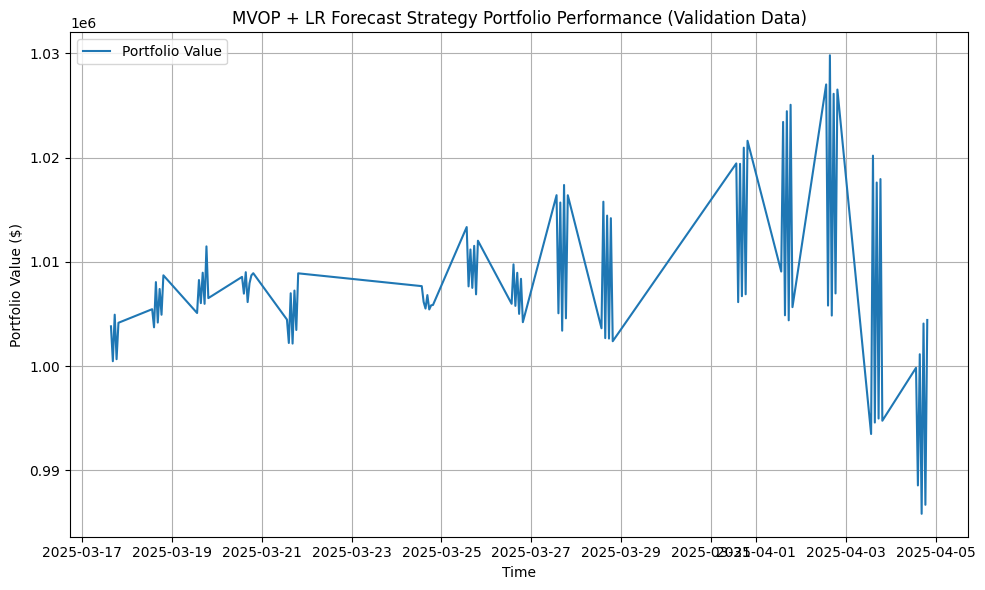


Final Portfolio Value: 1004427.66
Total Return: 0.44%
Sharpe Ratio of the Trading Strategy: -0.7994316099957984
Final Portfolio Value: 1004427.66
Total Return: 0.44%
Annualized Sharpe Ratio: 0.2483
Annual Return: 1.67%
Max Drawdown: -4.27%
Annual Volatility: 50.21%
Drawdown Patterns: 18
Average Trades per Hour: 5.0000
Number of Trades: 515
Average Holding Period (hrs): 0.85
Profit per Trade: 8.60
Average Profit per Hour: 10.16
Win Rate: 50.98%
                     portfolio_value  trade_count        profit  \
timestamp                                                         
2025-03-17 15:30:00     1.003817e+06            5   3816.694830   
2025-03-17 16:30:00     1.000469e+06            5  -3347.902628   
2025-03-17 17:30:00     1.004935e+06            5   4465.981951   
2025-03-17 18:30:00     1.000662e+06            5  -4272.308069   
2025-03-17 19:30:00     1.004158e+06            5   3495.722959   
2025-03-18 13:30:00     1.005461e+06            5   1302.725841   
2025-03-18 14:3

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------------
# 1. Data Loading Helper
# -------------------------------
def load_asset(filepath, price_col, datetime_col, new_name):
    df = pd.read_csv(filepath)
    df[datetime_col] = pd.to_datetime(df[datetime_col], format='%d/%m/%Y %H:%M')
    df = df.set_index(datetime_col)
    return df[[price_col]].rename(columns={price_col: new_name})

# -------------------------------
# 2. Train Linear Regression Models
# -------------------------------
def prepare_lag_features(series, lags=3):
    df = pd.DataFrame({'y': series})
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, lags+1)]].values
    y = df['y'].values
    return X, y

def train_linear_models(lags=3):
    models = {}
    btc_train = load_asset("BTC-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='BTC-USD')
    eth_train = load_asset("ETH-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='ETH-USD')
    aapl_train = load_asset("AAPL-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='AAPL')
    googl_train = load_asset("GOOGL-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='GOOGL')
    gld_train = load_asset("GLD-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='GLD')

    train_data = {
        'BTC-USD': btc_train,
        'ETH-USD': eth_train,
        'AAPL': aapl_train,
        'GOOGL': googl_train,
        'GLD': gld_train
}

    for asset, df in train_data.items():
        series = df[asset]
        X, y = prepare_lag_features(series, lags=lags)
        if len(X) == 0:
            continue
        model = LinearRegression()
        model.fit(X, y)
        models[asset] = model
        print(f"Trained LR model for {asset} with {len(X)} samples.")

    return models

lr_models = train_linear_models(lags=3)

# -------------------------------
# 3. Load & Align Validation Data
# -------------------------------
btc_test = load_asset("BTC-USD_hourly_test.csv", price_col='close', datetime_col='date', new_name='BTC-USD')
eth_test = load_asset("ETH-USD_hourly_test.csv", price_col='close', datetime_col='date', new_name='ETH-USD')
aapl_test = load_asset("AAPL-USD_hourly_test.csv", price_col='close', datetime_col='date', new_name='AAPL')
googl_test = load_asset("GOOGL-USD_hourly_test.csv", price_col='close', datetime_col='date', new_name='GOOGL')
gld_test = load_asset("GLD-USD_hourly_test.csv", price_col='close', datetime_col='date', new_name='GLD')

btc_test = btc_test.sort_index()
eth_test = eth_test.sort_index()
aapl_test = aapl_test.sort_index()
googl_test = googl_test.sort_index()
gld_test  = gld_test.sort_index()
target_index = aapl_test.index

btc_aligned = btc_test.reindex(target_index, method='ffill')
eth_aligned = eth_test.reindex(target_index, method='ffill')

price_data = pd.concat([btc_aligned, eth_aligned, aapl_test, googl_test, gld_test], axis=1)
price_data = price_data.sort_index().dropna()

print("Aligned Test Price Data:")
print(price_data.head())

# -------------------------------
# 4. Helper Functions for MVOP Strategy
# -------------------------------
def compute_returns(price_window):
    returns = price_window.pct_change(1).dropna()
    return returns

def compute_covariance(returns):
    return returns.cov()

def optimize_min_variance(cov_matrix):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix.values))
    constraints = [cp.sum(w) == 1, w>=0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    if w.value is None:
        raise Exception("Optimization did not converge")
    return pd.Series(w.value, index=cov_matrix.index)

def generate_signals(current_weights, target_weights, threshold=0.0):
    signals = {}
    for asset in target_weights.index:
        current_w = current_weights.get(asset, 0)
        diff = target_weights[asset] - current_w
        if diff > threshold:
            signals[asset] = 'BUY'
        elif diff < -threshold:
            signals[asset] = 'SELL'
        else:
            signals[asset] = 'HOLD'
    return signals

def execute_trades(signals, current_weights, target_weights):
    print("Executing trades:")
    for asset, signal in signals.items():
        print(f"{asset}: {signal} (Current: {current_weights.get(asset, 0):.2f}, Target: {target_weights[asset]:.2f})")

# -------------------------------
# 5. LR Forecasting Using Pre-Trained Models
# -------------------------------
def predict_next_hour_prices_with_pretrained(models, price_data, current_index, lags=3):
    predictions = {}
    for asset in price_data.columns:
        series = price_data[asset].iloc[current_index - lags: current_index]
        if len(series) < lags or asset not in models:
            predictions[asset] = series.iloc[-1]
            continue
        X_input = series.values.reshape(1, -1)
        predictions[asset] = models[asset].predict(X_input)[0]
    return predictions

def adjust_weights_with_forecast(target_weights, current_prices, predictions, k=1):
    adjusted_weights = target_weights.copy()
    for asset in target_weights.index:
        current_price = current_prices[asset]
        predicted_price = predictions[asset]
        forecast_return = (predicted_price - current_price) / current_price
        adjusted_weights[asset] *= (1 + k * forecast_return)
    adjusted_weights = adjusted_weights / adjusted_weights.sum()
    return adjusted_weights

# -------------------------------
# 6. MVOP Strategy Simulation with LR Forecasting
# -------------------------------
def MVOP_ML_strategy(price_data, lr_models, initial_capital=1000000, window=72, threshold=0.0, k=1, lags=3):
    assets = price_data.columns.tolist()
    current_weights = {asset: 1/len(assets) for asset in assets}
    portfolio_value = initial_capital

    initial_prices = price_data.iloc[window-1]
    holdings = {asset: (portfolio_value * current_weights[asset]) / initial_prices[asset] for asset in assets}

    results = []
    previous_portfolio_value = portfolio_value

    fee_rate = 0.00025

    for i in range(window, len(price_data)):
        current_time = price_data.index[i]
        current_prices = price_data.iloc[i]
        portfolio_value_before_trade = sum(holdings[asset] * current_prices[asset] for asset in assets)

        price_window = price_data.iloc[i-window:i]
        returns = compute_returns(price_window)
        if returns.empty:
            continue

        cov_matrix = compute_covariance(returns)
        target_weights = optimize_min_variance(cov_matrix)

        predictions = predict_next_hour_prices_with_pretrained(lr_models, price_data, current_index=i, lags=lags)
        target_weights = adjust_weights_with_forecast(target_weights, current_prices, predictions, k=k)

        current_portfolio_weights = {asset: (holdings[asset] * current_prices[asset]) / portfolio_value for asset in assets}
        signals = generate_signals(current_portfolio_weights, target_weights, threshold=threshold)

        trade_count = sum(1 for signal in signals.values() if signal in ['BUY', 'SELL'])

        if trade_count>0:
            fee_total = sum(
                fee_rate * portfolio_value_before_trade * abs(target_weights[asset] - current_portfolio_weights.get(asset, 0))
                for asset in assets if signals[asset] in ['BUY', 'SELL']
            )
            portfolio_value_after_trade = portfolio_value_before_trade - fee_total
            execute_trades(signals, current_portfolio_weights, target_weights)
            for asset in assets:
                alloc_value = portfolio_value * target_weights[asset]
                holdings[asset] = alloc_value / current_prices[asset]
            current_weights = target_weights.to_dict()
            portfolio_value = portfolio_value_after_trade
        else:
            portfolio_value = portfolio_value_before_trade

        profit = portfolio_value - previous_portfolio_value
        previous_portfolio_value = portfolio_value
        results.append({
            'timestamp': current_time,
            'portfolio_value': portfolio_value,
            'trade_count': trade_count,
            'profit': profit,
            'signals': signals,
            **{f"{asset}_weight": target_weights.get(asset, 0) for asset in assets}
        })

    results_df = pd.DataFrame(results).set_index('timestamp')
    final_portfolio_value = results_df['portfolio_value'].iloc[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital
    return results_df, total_return

# -------------------------------
# 7. Run Simulation & Plot Performance
# -------------------------------
results_df, total_return = MVOP_ML_strategy(
    price_data, lr_models,
    initial_capital=1000000,
    window=72,
    threshold=0.0,
    k=1,
    lags=3
)

# -------------------------------
# 8. Calculate Sharpe Ratio for the portfolio
# -------------------------------
def calculate_strategy_sharpe(results_df, risk_free_rate=0.01):
    returns = results_df['portfolio_value'].pct_change().dropna()
    sharpe = (returns.mean() - risk_free_rate) / returns.std()
    return sharpe
strategy_sharpe = calculate_strategy_sharpe(results_df)



def calculate_metrics(results_df, initial_capital, risk_free_rate=0.01):

    final_value = results_df['portfolio_value'].iloc[-1]
    total_return = final_value / initial_capital - 1

    total_hours = (results_df.index[-1] - results_df.index[0]).total_seconds() / 3600.0
    if total_hours <= 0:
        total_hours = 1e-9

    annual_factor = 1638 / total_hours
    annual_return = (1 + total_return) ** annual_factor - 1

    returns = results_df['portfolio_value'].pct_change().dropna()
    hourly_return = returns.mean()
    hourly_std = returns.std()

    rf_hourly = risk_free_rate / 1638
    if hourly_std != 0:
        sharpe_ratio_hourly = (hourly_return - rf_hourly) / hourly_std
    else:
        sharpe_ratio_hourly = 0.0
    annualized_sharpe = sharpe_ratio_hourly * np.sqrt(1638)

    rolling_max = results_df['portfolio_value'].cummax()
    drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    annual_volatility = hourly_std * np.sqrt(1638)

    dd_transition = ((drawdown.shift(1) >= 0) & (drawdown < 0)).sum()

    total_trades = results_df['trade_count'].sum()
    avg_trades_per_hour = total_trades / len(results_df) if len(results_df) > 0 else 0

    avg_holding_period_hrs = total_hours / total_trades if total_trades > 0 else 0

    total_profit = final_value - initial_capital
    profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

    avg_profit_per_hour = total_profit / total_hours

    wins = 0
    losses = 0
    for i in range(1, len(results_df)):
        row = results_df.iloc[i]
        if row['trade_count'] > 0:
            if row['profit'] > 0:
                wins += row['trade_count']
            elif row['profit'] < 0:
                losses += row['trade_count']

    if (wins + losses) > 0:
        win_rate = wins / (wins + losses)
    else:
        win_rate = 0.0

    return {
        "Final Portfolio Value": final_value,
        "Total Return": total_return,
        "Annualized Sharpe Ratio": annualized_sharpe,
        "Annual Return": annual_return,
        "Max Drawdown": max_drawdown,
        "Annual Volatility": annual_volatility,
        "Drawdown Patterns": dd_transition,
        "Average Trades per Hour": avg_trades_per_hour,
        "Number of Trades": total_trades,
        "Average Holding Period (hrs)": avg_holding_period_hrs,
        "Profit per Trade": profit_per_trade,
        "Average Profit per Hour": avg_profit_per_hour,
        "Win Rate": win_rate
    }

plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['portfolio_value'], label='Portfolio Value')
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.title("MVOP + LR Forecast Strategy Portfolio Performance (Validation Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(f"\nFinal Portfolio Value: {results_df['portfolio_value'].iloc[-1]:.2f}")
print(f"Total Return: {total_return*100:.2f}%")
print("Sharpe Ratio of the Trading Strategy:", strategy_sharpe)

metrics = calculate_metrics(results_df, initial_capital=1000000, risk_free_rate=0.01)
print(f"Final Portfolio Value: {metrics['Final Portfolio Value']:.2f}")
print(f"Total Return: {metrics['Total Return']*100:.2f}%")
print(f"Annualized Sharpe Ratio: {metrics['Annualized Sharpe Ratio']:.4f}")
print(f"Annual Return: {metrics['Annual Return']*100:.2f}%")
print(f"Max Drawdown: {metrics['Max Drawdown']*100:.2f}%")
print(f"Annual Volatility: {metrics['Annual Volatility']*100:.2f}%")
print(f"Drawdown Patterns: {metrics['Drawdown Patterns']}")
print(f"Average Trades per Hour: {metrics['Average Trades per Hour']:.4f}")
print(f"Number of Trades: {metrics['Number of Trades']}")
print(f"Average Holding Period (hrs): {metrics['Average Holding Period (hrs)']:.2f}")
print(f"Profit per Trade: {metrics['Profit per Trade']:.2f}")
print(f"Average Profit per Hour: {metrics['Average Profit per Hour']:.2f}")
print(f"Win Rate: {metrics['Win Rate']*100:.2f}%")
print(results_df)




# (Other Strategies Considered) MVOP + Linear Regression (VALIDATION DATA)

Trained LR model for BTC-USD with 8781 samples.
Trained LR model for ETH-USD with 8781 samples.
Trained LR model for AAPL with 1754 samples.
Trained LR model for GOOGL with 1753 samples.
Trained LR model for GLD with 1749 samples.
Aligned Validation Price Data:
                      BTC-USD  ETH-USD      AAPL       GOOGL         GLD
date                                                                    
2025-01-02 14:30:00  97180.47  3492.91  245.7399  190.399990  244.220001
2025-01-02 15:30:00  96366.93  3460.12  244.8950  190.225010  244.410004
2025-01-02 16:30:00  97130.94  3465.90  243.4286  188.360000  245.130005
2025-01-02 17:30:00  96652.77  3448.00  242.6862  188.710010  245.110001
2025-01-02 18:30:00  97189.36  3461.06  242.4884  189.054993  244.990005
Executing trades:
BTC-USD: SELL (Current: 0.20, Target: 0.00)
ETH-USD: SELL (Current: 0.20, Target: 0.00)
AAPL: SELL (Current: 0.20, Target: 0.13)
GOOGL: SELL (Current: 0.20, Target: 0.06)
GLD: BUY (Current: 0.20, Target: 0.81)

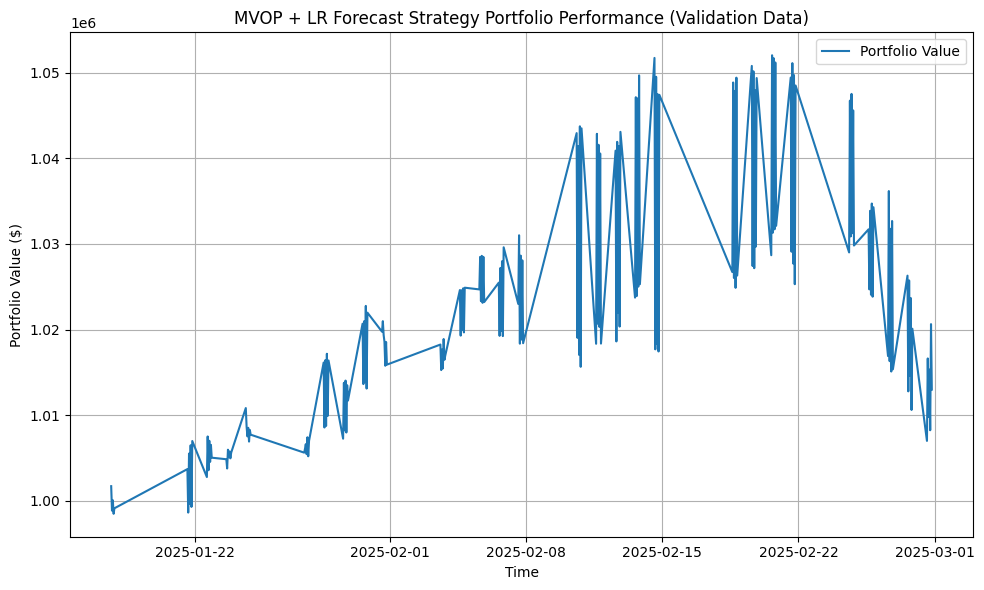


Final Portfolio Value: 1012989.61
Total Return: 1.30%
Sharpe Ratio of the Trading Strategy: -0.6817620878699596
Final Portfolio Value: 1012989.61
Total Return: 1.30%
Annualized Sharpe Ratio: 0.4305
Annual Return: 2.11%
Max Drawdown: -4.28%
Annual Volatility: 58.42%
Drawdown Patterns: 26
Average Trades per Hour: 5.0000
Number of Trades: 1005
Average Holding Period (hrs): 1.01
Profit per Trade: 12.92
Average Profit per Hour: 12.84
Win Rate: 49.50%
                     portfolio_value  trade_count        profit  \
timestamp                                                         
2025-01-17 16:30:00     1.001705e+06            5   1705.475929   
2025-01-17 17:30:00     9.988509e+05            5  -2854.625858   
2025-01-17 18:30:00     1.000064e+06            5   1213.136734   
2025-01-17 19:30:00     9.984782e+05            5  -1585.770395   
2025-01-17 20:30:00     9.991228e+05            5    644.543270   
2025-01-21 14:30:00     1.003700e+06            5   4577.313993   
2025-01-21 15

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------------
# 1. Data Loading Helper
# -------------------------------
def load_asset(filepath, price_col, datetime_col, new_name):
    df = pd.read_csv(filepath)
    df[datetime_col] = pd.to_datetime(df[datetime_col], format='%d/%m/%Y %H:%M')
    df = df.set_index(datetime_col)
    return df[[price_col]].rename(columns={price_col: new_name})

# -------------------------------
# 2. Train Linear Regression Models
# -------------------------------
def prepare_lag_features(series, lags=3):
    df = pd.DataFrame({'y': series})
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, lags+1)]].values
    y = df['y'].values
    return X, y

def train_linear_models(lags=3):
    models = {}
    btc_train = load_asset("BTC-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='BTC-USD')
    eth_train = load_asset("ETH-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='ETH-USD')
    aapl_train = load_asset("AAPL-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='AAPL')
    googl_train = load_asset("GOOGL-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='GOOGL')
    gld_train = load_asset("GLD-USD_hourly_train.csv", price_col='close', datetime_col='date', new_name='GLD')

    train_data = {
        'BTC-USD': btc_train,
        'ETH-USD': eth_train,
        'AAPL': aapl_train,
        'GOOGL': googl_train,
        'GLD': gld_train
}
    for asset, df in train_data.items():
        series = df[asset]
        X, y = prepare_lag_features(series, lags=lags)
        if len(X) == 0:
            continue
        model = LinearRegression()
        model.fit(X, y)
        models[asset] = model
        print(f"Trained LR model for {asset} with {len(X)} samples.")

    return models

lr_models = train_linear_models(lags=3)

# -------------------------------
# 3. Load & Align Validation Data
# -------------------------------
btc_val = load_asset("BTC-USD_hourly_val.csv", price_col='close', datetime_col='date', new_name='BTC-USD')
eth_val = load_asset("ETH-USD_hourly_val.csv", price_col='close', datetime_col='date', new_name='ETH-USD')
aapl_val = load_asset("AAPL-USD_hourly_val.csv", price_col='close', datetime_col='date', new_name='AAPL')
googl_val = load_asset("GOOGL-USD_hourly_val.csv", price_col='close', datetime_col='date', new_name='GOOGL')
gld_val = load_asset("GLD-USD_hourly_val.csv", price_col='close', datetime_col='date', new_name='GLD')

btc_val = btc_val.sort_index()
eth_val = eth_val.sort_index()
aapl_val = aapl_val.sort_index()
googl_val = googl_val.sort_index()
gld_val  = gld_val.sort_index()
target_index = aapl_val.index

btc_aligned = btc_val.reindex(target_index, method='ffill')
eth_aligned = eth_val.reindex(target_index, method='ffill')

price_data = pd.concat([btc_aligned, eth_aligned, aapl_val, googl_val, gld_val], axis=1)
price_data = price_data.sort_index().dropna()
print("Aligned Validation Price Data:")
print(price_data.head())

# -------------------------------
# 4. Helper Functions for MVOP Strategy
# -------------------------------
def compute_returns(price_window):
    returns = price_window.pct_change(1).dropna()
    return returns

def compute_covariance(returns):
    return returns.cov()

def optimize_min_variance(cov_matrix):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix.values))
    constraints = [cp.sum(w) == 1, w>=0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    if w.value is None:
        raise Exception("Optimization did not converge")
    return pd.Series(w.value, index=cov_matrix.index)

def generate_signals(current_weights, target_weights, threshold=0.0):
    signals = {}
    for asset in target_weights.index:
        current_w = current_weights.get(asset, 0)
        diff = target_weights[asset] - current_w
        if diff > threshold:
            signals[asset] = 'BUY'
        elif diff < -threshold:
            signals[asset] = 'SELL'
        else:
            signals[asset] = 'HOLD'
    return signals

def execute_trades(signals, current_weights, target_weights):
    print("Executing trades:")
    for asset, signal in signals.items():
        print(f"{asset}: {signal} (Current: {current_weights.get(asset, 0):.2f}, Target: {target_weights[asset]:.2f})")

# -------------------------------
# 5. LR Forecasting Using Pre-Trained Models
# -------------------------------
def predict_next_hour_prices_with_pretrained(models, price_data, current_index, lags=3):
    predictions = {}
    for asset in price_data.columns:
        series = price_data[asset].iloc[current_index - lags: current_index]
        if len(series) < lags or asset not in models:
            predictions[asset] = series.iloc[-1]
            continue
        X_input = series.values.reshape(1, -1)
        predictions[asset] = models[asset].predict(X_input)[0]
    return predictions

def adjust_weights_with_forecast(target_weights, current_prices, predictions, k=1):
    adjusted_weights = target_weights.copy()
    for asset in target_weights.index:
        current_price = current_prices[asset]
        predicted_price = predictions[asset]
        forecast_return = (predicted_price - current_price) / current_price
        adjusted_weights[asset] *= (1 + k * forecast_return)
    adjusted_weights = adjusted_weights / adjusted_weights.sum()
    return adjusted_weights

# -------------------------------
# 6. MVOP Strategy Simulation with LR Forecasting
# -------------------------------
def MVOP_ML_strategy(price_data, lr_models, initial_capital=1000000, window=72, threshold=0.0, k=1, lags=3):
    assets = price_data.columns.tolist()
    current_weights = {asset: 1/len(assets) for asset in assets}
    portfolio_value = initial_capital

    initial_prices = price_data.iloc[window-1]
    holdings = {asset: (portfolio_value * current_weights[asset]) / initial_prices[asset] for asset in assets}

    results = []
    previous_portfolio_value = portfolio_value

    fee_rate = 0.00025

    for i in range(window, len(price_data)):
        current_time = price_data.index[i]
        current_prices = price_data.iloc[i]
        portfolio_value_before_trade = sum(holdings[asset] * current_prices[asset] for asset in assets)

        price_window = price_data.iloc[i-window:i]
        returns = compute_returns(price_window)
        if returns.empty:
            continue

        cov_matrix = compute_covariance(returns)
        target_weights = optimize_min_variance(cov_matrix)

        predictions = predict_next_hour_prices_with_pretrained(lr_models, price_data, current_index=i, lags=lags)
        target_weights = adjust_weights_with_forecast(target_weights, current_prices, predictions, k=k)

        current_portfolio_weights = {asset: (holdings[asset] * current_prices[asset]) / portfolio_value for asset in assets}
        signals = generate_signals(current_portfolio_weights, target_weights, threshold=threshold)

        trade_count = sum(1 for signal in signals.values() if signal in ['BUY', 'SELL'])

        if trade_count>0:
            fee_total = sum(
                fee_rate * portfolio_value_before_trade * abs(target_weights[asset] - current_portfolio_weights.get(asset, 0))
                for asset in assets if signals[asset] in ['BUY', 'SELL']
            )
            portfolio_value_after_trade = portfolio_value_before_trade - fee_total
            execute_trades(signals, current_portfolio_weights, target_weights)
            for asset in assets:
                alloc_value = portfolio_value * target_weights[asset]
                holdings[asset] = alloc_value / current_prices[asset]
            current_weights = target_weights.to_dict()
            portfolio_value = portfolio_value_after_trade
        else:
            portfolio_value = portfolio_value_before_trade

        profit = portfolio_value - previous_portfolio_value
        previous_portfolio_value = portfolio_value
        results.append({
            'timestamp': current_time,
            'portfolio_value': portfolio_value,
            'trade_count': trade_count,
            'profit': profit,
            'signals': signals,
            **{f"{asset}_weight": target_weights.get(asset, 0) for asset in assets}
        })

    results_df = pd.DataFrame(results).set_index('timestamp')
    final_portfolio_value = results_df['portfolio_value'].iloc[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital
    return results_df, total_return
# -------------------------------
# 7. Run Simulation & Plot Performance
# -------------------------------
results_df, total_return = MVOP_ML_strategy(
    price_data, lr_models,
    initial_capital=1000000,
    window=72,
    threshold=0.0,
    k=1,
    lags=3
)

# -------------------------------
# 8. Calculate Sharpe Ratio for the portfolio
# -------------------------------
def calculate_strategy_sharpe(results_df, risk_free_rate=0.01):
    returns = results_df['portfolio_value'].pct_change().dropna()
    sharpe = (returns.mean() - risk_free_rate) / returns.std()
    return sharpe
strategy_sharpe = calculate_strategy_sharpe(results_df)



def calculate_metrics(results_df, initial_capital, risk_free_rate=0.01):

    final_value = results_df['portfolio_value'].iloc[-1]
    total_return = final_value / initial_capital - 1

    total_hours = (results_df.index[-1] - results_df.index[0]).total_seconds() / 3600.0
    if total_hours <= 0:
        total_hours = 1e-9

    annual_factor = 1638 / total_hours
    annual_return = (1 + total_return) ** annual_factor - 1

    returns = results_df['portfolio_value'].pct_change().dropna()
    hourly_return = returns.mean()
    hourly_std = returns.std()

    rf_hourly = risk_free_rate / 1638
    if hourly_std != 0:
        sharpe_ratio_hourly = (hourly_return - rf_hourly) / hourly_std
    else:
        sharpe_ratio_hourly = 0.0
    annualized_sharpe = sharpe_ratio_hourly * np.sqrt(1638)

    rolling_max = results_df['portfolio_value'].cummax()
    drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    annual_volatility = hourly_std * np.sqrt(1638)

    dd_transition = ((drawdown.shift(1) >= 0) & (drawdown < 0)).sum()

    total_trades = results_df['trade_count'].sum()
    avg_trades_per_hour = total_trades / len(results_df) if len(results_df) > 0 else 0

    avg_holding_period_hrs = total_hours / total_trades if total_trades > 0 else 0

    total_profit = final_value - initial_capital
    profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

    avg_profit_per_hour = total_profit / total_hours

    wins = 0
    losses = 0
    for i in range(1, len(results_df)):
        row = results_df.iloc[i]
        if row['trade_count'] > 0:
            if row['profit'] > 0:
                wins += row['trade_count']
            elif row['profit'] < 0:
                losses += row['trade_count']

    if (wins + losses) > 0:
        win_rate = wins / (wins + losses)
    else:
        win_rate = 0.0

    return {
        "Final Portfolio Value": final_value,
        "Total Return": total_return,
        "Annualized Sharpe Ratio": annualized_sharpe,
        "Annual Return": annual_return,
        "Max Drawdown": max_drawdown,
        "Annual Volatility": annual_volatility,
        "Drawdown Patterns": dd_transition,
        "Average Trades per Hour": avg_trades_per_hour,
        "Number of Trades": total_trades,
        "Average Holding Period (hrs)": avg_holding_period_hrs,
        "Profit per Trade": profit_per_trade,
        "Average Profit per Hour": avg_profit_per_hour,
        "Win Rate": win_rate
    }



plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['portfolio_value'], label='Portfolio Value')
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.title("MVOP + LR Forecast Strategy Portfolio Performance (Validation Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(f"\nFinal Portfolio Value: {results_df['portfolio_value'].iloc[-1]:.2f}")
print(f"Total Return: {total_return*100:.2f}%")
print("Sharpe Ratio of the Trading Strategy:", strategy_sharpe)
# Calculate all metrics
metrics = calculate_metrics(results_df, initial_capital=1000000, risk_free_rate=0.01)
# Print them in the desired format
print(f"Final Portfolio Value: {metrics['Final Portfolio Value']:.2f}")
print(f"Total Return: {metrics['Total Return']*100:.2f}%")
print(f"Annualized Sharpe Ratio: {metrics['Annualized Sharpe Ratio']:.4f}")
print(f"Annual Return: {metrics['Annual Return']*100:.2f}%")
print(f"Max Drawdown: {metrics['Max Drawdown']*100:.2f}%")
print(f"Annual Volatility: {metrics['Annual Volatility']*100:.2f}%")
print(f"Drawdown Patterns: {metrics['Drawdown Patterns']}")
print(f"Average Trades per Hour: {metrics['Average Trades per Hour']:.4f}")
print(f"Number of Trades: {metrics['Number of Trades']}")
print(f"Average Holding Period (hrs): {metrics['Average Holding Period (hrs)']:.2f}")
print(f"Profit per Trade: {metrics['Profit per Trade']:.2f}")
print(f"Average Profit per Hour: {metrics['Average Profit per Hour']:.2f}")
print(f"Win Rate: {metrics['Win Rate']*100:.2f}%")
print(results_df)

# (Other Strategies Considered) MVOP, Kelly Criterion, and Markowtiz Regime Switching

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

! pip install backtrader statsmodels
import backtrader as bt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# =============================================================================
# Data Handler
# =============================================================================

class DataHandler:
    """
    Handles reading the CSV data and calculating technical indicators
    for a single asset (e.g., Bitcoin).
    """
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.df = pd.DataFrame()

    def load_data(self):
        """
        Load data from the provided CSV file.
        Assumes the CSV has at least these columns:
        ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', ...]
        """
        print(f"Loading data from {self.csv_path}...")
        self.df = pd.read_csv(
            self.csv_path,
            parse_dates=['Datetime'],
            index_col='Datetime'
        )
        self.df.sort_index(inplace=True)
        print("Data loading complete.")
        return self.df

    def calculate_technical_indicators(self):
        """Calculate technical indicators for feature engineering."""
        print("Calculating technical indicators...")

        # 1. Returns
        self.df['Returns'] = self.df['Close'].pct_change()

        # 2. Moving Averages
        self.df['SMA_10'] = self.df['Close'].rolling(window=10).mean()
        self.df['SMA_30'] = self.df['Close'].rolling(window=30).mean()
        self.df['SMA_60'] = self.df['Close'].rolling(window=60).mean()

        # 3. RSI (14-period)
        delta = self.df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.df['RSI'] = 100 - (100 / (1 + rs))

        # 4. Momentum
        self.df['Momentum_10'] = self.df['Close'].pct_change(10)
        self.df['Momentum_30'] = self.df['Close'].pct_change(30)

        # 5. Volatility
        self.df['Volatility_30'] = self.df['Returns'].rolling(window=30).std()

        # 6. Price relative to SMA
        self.df['Price_to_SMA10'] = self.df['Close'] / self.df['SMA_10']
        self.df['Price_to_SMA30'] = self.df['Close'] / self.df['SMA_30']

        # 7. Moving average convergence/divergence (MACD)
        self.df['EMA_12'] = self.df['Close'].ewm(span=12, adjust=False).mean()
        self.df['EMA_26'] = self.df['Close'].ewm(span=26, adjust=False).mean()
        self.df['MACD'] = self.df['EMA_12'] - self.df['EMA_26']
        self.df['MACD_Signal'] = self.df['MACD'].ewm(span=9, adjust=False).mean()

        # Optional Target (not strictly needed for Markov Switching):
        self.df['Target'] = (self.df['Close'].shift(-5) > self.df['Close']).astype(int)

        # Drop rows that contain NaN from rolling calculations
        self.df.dropna(inplace=True)
        print("Technical indicators calculation complete.")
        return self.df


# =============================================================================
# Markov Switching Trainer
# =============================================================================

class MarkovSwitchingTrainer:
    """
    Fits a Markov Switching model (via statsmodels) to the asset’s returns,
    with exogenous features. We then derive a 'Signal' from the probability
    of being in a specific "bullish" regime.
    """
    def __init__(self, df):
        # Keep a reference to the DataFrame
        self.df = df

        # Which columns to use as exogenous features
        self.feature_columns = [
            'SMA_10', 'SMA_30', 'SMA_60',
            'RSI', 'Momentum_10', 'Momentum_30',
            'Volatility_30', 'Price_to_SMA10', 'Price_to_SMA30',
            'MACD', 'MACD_Signal'
        ]

        self.model_fit = None
        self.scaler = None

    def train_model(self, k_regimes=2):
        """
        Train a Markov Switching model on the 'Returns' column,
        using the specified columns as exogenous regressors.
        """
        print("Training Markov Switching model...")

        # Prepare endog (the time series we want to model)
        endog = self.df['Returns'].values

        # Prepare exogenous features
        X = self.df[self.feature_columns].values

        # Scale the exogenous features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # Fit a MarkovRegression with k_regimes=2 for bull/bear
        # switching_variance=True allows each regime to have its own variance
        # switching_exog=True allows each regime to have different coefficients for exog
        model = MarkovRegression(
            endog=endog,
            exog=X_scaled,
            k_regimes=k_regimes,
            switching_variance=True,
            switching_exog=True
        )
        self.model_fit = model.fit(maxiter=1000, em_iter=50, cov_type='opg')
        print("Markov Switching model fitting complete.")
        print(self.model_fit.summary())

        return self.model_fit

    def add_signals_to_df(self):
        """
        Use the fitted Markov Switching model to compute the smoothed regime
        probabilities. Then derive a trading signal from the probability
        of being in regime #1 (which we can interpret as 'bullish').
        Also add a 'Regime' column with 'BULL' or 'BEAR'.
        """
        if self.model_fit is None:
            raise ValueError("No Markov Switching model has been trained yet.")

        # Get the smoothed probability of being in regime 1 for each time step
        prob_bullish = self.model_fit.smoothed_marginal_probabilities[:, 1]

        # Store probabilities in the main DataFrame
        self.df['Signal_Prob'] = prob_bullish

        # Numeric signal for backtesting: 1 if bull, 0 if bear
        self.df['Signal'] = (prob_bullish >= 0.5).astype(int)

        # Human-readable regime label
        self.df['Regime'] = np.where(prob_bullish >= 0.5, 'BULL', 'BEAR')

        return self.df

    def get_signal(self, latest_data):
        """
        Optionally return the regime label ('BULL'/'BEAR') for the latest row.
        Because statsmodels MarkovRegression doesn't have a direct out-of-sample
        prediction method, we just return the last known probability.
        """
        if self.model_fit is None:
            raise ValueError("No Markov Switching model is trained.")

        # For demonstration, we just use the last row's probability
        prob_bullish = self.df['Signal_Prob'].iloc[-1]
        regime_label = 'BULL' if prob_bullish >= 0.5 else 'BEAR'

        return regime_label, prob_bullish


# =============================================================================
# Backtrader Strategy
# =============================================================================

class MLStrategy(bt.Strategy):

    params = (
        ('signal_series', None),   # Pandas series of 0 or 1 signals
        ('prob_series', None),     # Pandas series of predicted probabilities
        ('threshold', 0.4),        # Probability threshold to decide whether to act
    )

    def __init__(self):
        # Keep track of whether we already have a position
        self.order = None

    def next(self):
        # Get the current date index from Backtrader
        current_dt = self.datas[0].datetime.date(0)

        # Convert to a pandas Timestamp so we can align with the signal series
        current_ts = pd.Timestamp(current_dt)

        # If this date exists in our signal series, get the signal
        if current_ts in self.p.signal_series.index:
            signal = self.p.signal_series.loc[current_ts]
            probability = self.p.prob_series.loc[current_ts]

            # Check existing position
            position_size = self.getposition(self.datas[0]).size

            # If probability > threshold, we trust the signal
            if probability >= self.p.threshold:
                # If signal == 1 (buy) and we have no position, buy
                if signal == 1 and position_size == 0:
                    self.order = self.buy()
                    print(f"{current_dt} BUY signal (prob={probability:.2f}), Price={self.datas[0].close[0]}")
                # If signal == 0 (sell) and we have a position, sell
                elif signal == 0 and position_size > 0:
                    self.order = self.sell()
                    print(f"{current_dt} SELL signal (prob={probability:.2f}), Price={self.datas[0].close[0]}")


# =============================================================================
# Main Function
# =============================================================================

def run_markov_switching_system(csv_path):

    # 1. Load and preprocess data
    data_handler = DataHandler(csv_path)
    df = data_handler.load_data()
    df = data_handler.calculate_technical_indicators()

    # 2. Train the Markov Switching model
    ms_trainer = MarkovSwitchingTrainer(df)
    ms_trainer.train_model(k_regimes=2)  # for example, 2 regimes (Bull/Bear)
    df = ms_trainer.add_signals_to_df()

    # 3. Print last few rows to see BULL/BEAR
    print("\nSample of final DataFrame with regime classification:")
    print(df[['Close', 'Returns', 'Signal_Prob', 'Signal', 'Regime']].tail(10))

    # 4. Backtest using Backtrader
    print("\nRunning backtest...")
    cerebro = bt.Cerebro()

    # Convert our df into a Backtrader 'feed'
    feed = bt.feeds.PandasData(dataname=df, fromdate=df.index[0], todate=df.index[-1])
    cerebro.adddata(feed, name='Asset')

    # Add our strategy, pass the signals as parameters
    cerebro.addstrategy(
        MLStrategy,
        signal_series=df['Signal'],
        prob_series=df['Signal_Prob'],
        threshold=0.6  # example threshold
    )

    # Starting capital
    initial_capital = 100000.0
    cerebro.broker.setcash(initial_capital)

    # Set commission (for example, 0.1%)
    cerebro.broker.setcommission(commission=0.001)

    # Print initial portfolio value
    print(f"Starting Portfolio Value: ${cerebro.broker.getvalue():.2f}")

    # Run the backtest
    cerebro.run()

    # Print final portfolio value
    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():.2f}")

    # Plot the backtest result
    cerebro.plot(style='candlestick')
    return df[['Regime']]

regimes = run_markov_switching_system("SPY-hourly.csv")

Loading data from SPY-hourly.csv...
Data loading complete.
Calculating technical indicators...
Technical indicators calculation complete.
Training Markov Switching model...
Markov Switching model fitting complete.
                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                 2134
Model:               MarkovRegression   Log Likelihood               10656.840
Date:                Sat, 05 Apr 2025   AIC                         -21257.680
Time:                        13:56:54   BIC                         -21099.039
Sample:                             0   HQIC                        -21199.621
                               - 2134                                         
Covariance Type:                  opg                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.9

<IPython.core.display.Javascript object>

In [ ]:
#Validation Period

! pip install PyPortfolioOpt
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
import matplotlib.pyplot as plt
import datetime

#MVOP and Kelly criterion portfolio allocation
def allocation(prices, regime, window_start, window_end):
    prices = prices.dropna()
    log_returns = np.log(prices / prices.shift(1))
    log_returns = log_returns.dropna()
    mu = log_returns[window_start: window_end].mean() * 252 * 24
    std = log_returns[window_start: window_end].std() * np.sqrt(252 * 24)
    S = log_returns[window_start: window_end].cov()
    ef = EfficientFrontier(mu, S)
    try:
        ef.max_sharpe(risk_free_rate = 0)
    except:
        ef = EfficientFrontier(mu, S)
        ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    kelly_fraction = mu / (std ** 2).mean()
    kelly_fraction = kelly_fraction / kelly_fraction.sum()
    allocations_kelly = pd.DataFrame(kelly_fraction, columns=['Kelly Allocation'])
    allocations_mvo = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['MVO Allocation'])
    weight = 0
    if regime == "BEAR":
        weight = 1
    else:
        weight = 0
    final_allocations = weight * allocations_mvo["MVO Allocation"] + (1 - weight) * allocations_kelly["Kelly Allocation"]
    allocations = pd.DataFrame(final_allocations, columns=['Final Allocation'])
    return allocations

#retrieving ticker data
def get_full_hourly_data(ticker, start_date='2024-01-01', end_date='2025-02-28'):
    all_data = []
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + datetime.timedelta(days=59), end_date)
        chunk = yf.download(
            ticker,
            interval="1h",
            start=current_start.strftime('%Y-%m-%d'),
            end=(current_end + datetime.timedelta(days=1)).strftime('%Y-%m-%d'),
            progress=False
        )

        all_data.append(chunk)
        current_start = current_end + datetime.timedelta(days=1)

    # Combine and clean up
    full_data = pd.concat(all_data)
    full_data = full_data[~full_data.index.duplicated(keep='first')]
    return full_data
aapl = get_full_hourly_data('AAPL')['Close']
btc = get_full_hourly_data('BTC-USD')['Close']
eth = get_full_hourly_data('ETH-USD')['Close']
googl = get_full_hourly_data('GOOGL')['Close']
gld = get_full_hourly_data('GLD')['Close']
btc.index = btc.index + pd.Timedelta(minutes=30)
eth.index = eth.index + pd.Timedelta(minutes=30)
prices = pd.concat([aapl, googl, btc, eth, gld], axis = 1, join = 'inner')
start_index = prices.index.get_loc("2025-01-02 15:30:00+00:00")
end_index = prices.index.get_loc("2025-02-28 20:30:00+00:00")
validation_regime = regimes.loc["2025-01-02 15:30:00+00:00":"2025-02-28 20:30:00+00:00"]
count = 0
data = {"BTC-USD":[], "ETH-USD":[], "AAPL": [], "GOOGL": [], "GLD": []}
timestamps = []

#finding allocation per trading period based on prices, mean, volatility, and regime switching
for i in range(start_index, end_index + 1):
    regime_marker = validation_regime.iloc[count]['Regime']
    allo = allocation(prices, regime_marker, 0 + count, i)
    data["BTC-USD"].append(allo.loc["BTC-USD", "Final Allocation"])
    data["ETH-USD"].append(allo.loc["ETH-USD", "Final Allocation"])
    data["AAPL"].append(allo.loc["AAPL", "Final Allocation"])
    data["GOOGL"].append(allo.loc["GOOGL", "Final Allocation"])
    data["GLD"].append(allo.loc["GLD", "Final Allocation"])
    timestamps.append(prices.index[i])
    count += 1
allocation_df = pd.DataFrame(data, index = timestamps)
allocation_df.index.name = "Timestamp"
allocation_df
prices = prices.loc["2025-01-02 15:30:00+00:00":]
initial_capital = 1_000_000
capital = initial_capital
portfolio_values = [capital]
prices = prices[allocation_df.columns].loc[allocation_df.index]
aapl_allocation = [allocation_df.iloc[0]['AAPL']]
googl_allocation = [allocation_df.iloc[0]['GOOGL']]
btc_allocation = [allocation_df.iloc[0]['BTC-USD']]
eth_allocation = [allocation_df.iloc[0]['ETH-USD']]
gld_allocation = [allocation_df.iloc[0]['GLD']]
aapl_trade = ["BUY " + str((allocation_df.iloc[0]['AAPL'] * 1000000) / prices.iloc[0]['AAPL'])]
googl_trade = ["BUY " + str((allocation_df.iloc[0]['GOOGL'] * 1000000) / prices.iloc[0]['GOOGL'])]
btc_trade = ["BUY " + str((allocation_df.iloc[0]['BTC-USD'] * 1000000) / prices.iloc[0]['BTC-USD'])]
eth_trade = ["BUY " + str((allocation_df.iloc[0]['ETH-USD'] * 1000000) / prices.iloc[0]['ETH-USD'])]
gld_trade = ["BUY " + str((allocation_df.iloc[0]['GLD'] * 1000000) / prices.iloc[0]['GLD'])]
num_trades = [1]

for i in range(1, len(allocation_df)):
    trades_per_interval = 0
    w = allocation_df.iloc[i - 1]
    p0 = prices.iloc[i - 1]
    p1 = prices.iloc[i]
    asset_returns = p1 / p0
    portfolio_return = (w * asset_returns).sum()
    capital *= portfolio_return
    portfolio_values.append(capital)
    aapl_allocation.append(allocation_df.iloc[i]['AAPL'])
    googl_allocation.append(allocation_df.iloc[i]['GOOGL'])
    btc_allocation.append(allocation_df.iloc[i]['BTC-USD'])
    eth_allocation.append(allocation_df.iloc[i]['ETH-USD'])
    gld_allocation.append(allocation_df.iloc[i]['GLD'])
    aapl_capital = aapl_allocation[i] * capital
    aapl_previous_capital = aapl_allocation[i - 1] * capital
    aapl_difference = aapl_capital / prices.iloc[i]['AAPL'] - aapl_previous_capital / prices.iloc[i - 1]['AAPL']
    aapl_raw_difference = aapl_allocation[i] - aapl_allocation[i-1]
    if aapl_raw_difference > 0.011:
        aapl_trade.append("BUY " + str(aapl_difference))
        capital -= (aapl_difference) * prices.iloc[i]['AAPL'] * 0.00025
        trades_per_interval += 1
    elif aapl_raw_difference < -0.011:
        aapl_trade.append("SELL " + str( - aapl_difference))
        capital -= ( - aapl_difference) * prices.iloc[i]['AAPL'] * 0.00025
        trades_per_interval += 1
    else:
        aapl_trade.append("HOLD")
    googl_capital = googl_allocation[i] * capital
    googl_previous_capital = googl_allocation[i - 1] * capital
    googl_difference = googl_capital / prices.iloc[i]['GOOGL'] - googl_previous_capital / prices.iloc[i - 1]['GOOGL']
    googl_raw_difference = googl_allocation[i] - googl_allocation[i-1]
    if googl_raw_difference > 0.011:
        googl_trade.append("BUY " + str(googl_difference))
        capital -= (googl_difference) * prices.iloc[i]['GOOGL'] * 0.00025
        trades_per_interval += 1
    elif googl_raw_difference < -0.011:
        googl_trade.append("SELL " + str( - googl_difference))
        capital -= (- googl_difference) * prices.iloc[i]['GOOGL'] * 0.00025
        trades_per_interval += 1
    else:
        googl_trade.append("HOLD")
    btc_capital = btc_allocation[i] * capital
    btc_previous_capital = btc_allocation[i - 1] * capital
    btc_difference = btc_capital / prices.iloc[i]['BTC-USD'] - btc_previous_capital / prices.iloc[i - 1]['BTC-USD']
    btc_raw_difference = btc_allocation[i] - btc_allocation[i-1]
    if btc_raw_difference > 0.011:
        btc_trade.append("BUY " + str(btc_difference))
        capital -= (btc_difference) * prices.iloc[i]['BTC-USD'] * 0.00025
        trades_per_interval += 1
    elif btc_raw_difference < -0.011:
        btc_trade.append("SELL " + str( - btc_difference))
        capital -= (btc_difference) * prices.iloc[i]['BTC-USD'] * 0.00025
        trades_per_interval += 1
    else:
        btc_trade.append("HOLD")
    eth_capital = eth_allocation[i] * capital
    eth_previous_capital = eth_allocation[i - 1] * capital
    eth_difference = eth_capital / prices.iloc[i]['ETH-USD'] - eth_previous_capital / prices.iloc[i - 1]['ETH-USD']
    eth_raw_difference = eth_allocation[i] - eth_allocation[i-1]
    if eth_raw_difference > 0.011:
        eth_trade.append("BUY " + str(eth_difference))
        capital -= (eth_difference) * prices.iloc[i]['ETH-USD'] * 0.00025
        trades_per_interval += 1
    elif eth_raw_difference < -0.011:
        eth_trade.append("SELL " + str( - eth_difference))
        capital -= ( - eth_difference) * prices.iloc[i]['ETH-USD'] * 0.00025
        trades_per_interval += 1
    else:
        eth_trade.append("HOLD")

    gld_capital = gld_allocation[i] * capital
    gld_previous_capital = gld_allocation[i - 1] * capital
    gld_difference = gld_capital / prices.iloc[i]['GLD'] - gld_previous_capital / prices.iloc[i - 1]['GLD']
    gld_raw_difference = gld_allocation[i] - gld_allocation[i-1]
    if gld_raw_difference > 0.011:
        gld_trade.append("BUY " + str(gld_difference))
        capital -= (gld_difference) * prices.iloc[i]['GLD'] * 0.00025
        trades_per_interval += 1
    elif gld_raw_difference < -0.011:
        gld_trade.append("SELL " + str( - gld_difference))
        capital -= (-gld_difference) * prices.iloc[i]['GLD'] * 0.00025
        trades_per_interval += 1
    else:
        gld_trade.append("HOLD")
    if trades_per_interval > 0:
      trades_per_interval = 1
    num_trades.append(trades_per_interval)
portfolio_df = pd.DataFrame({
    "Portfolio Value": portfolio_values,
    "AAPL Allocation": aapl_allocation,
    "GOOGL Allocation": googl_allocation,
    "BTC-USD Allocation": btc_allocation,
    "ETH-USD Allocation": eth_allocation,
    "GLD Allocation": gld_allocation,
    "AAPL Trade": aapl_trade,
    "GOOGL Trade": googl_trade,
    "BTC-USD Trade": btc_trade,
    "ETH-USD Trade": eth_trade,
    'GLD Trade': gld_trade,
    "Number of Trades": num_trades
}, index=allocation_df.index)
portfolio_df['Profit'] = (portfolio_df["Portfolio Value"] / portfolio_df["Portfolio Value"].shift(1) - 1) * portfolio_df['Portfolio Value'].shift(1)
portfolio_df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 11.0 MB/s eta 0:00:00
YF.download() has changed argument auto_adjust default to True


,Portfolio Value,AAPL Allocation,GOOGL Allocation,BTC-USD Allocation,ETH-USD Allocation,GLD Allocation,AAPL Trade,GOOGL Trade,BTC-USD Trade,ETH-USD Trade,GLD Trade,Number of Trades,Profit
Timestamp,,,,,,,,,,,,,
2025-01-02 15:30:00+00:00,1.000000e+06,0.135670,0.138210,0.118640,0.000000,0.607480,BUY 553.9925177447012,BUY 726.5606285473826,BUY 1.230517413987506,BUY 0.0,BUY 2477.8919518913717,1,NaN
2025-01-02 16:30:00+00:00,9.986292e+05,0.133891,0.159199,0.387000,0.194827,0.125083,HOLD,BUY 118.46259278604032,BUY 2.7486955938694684,BUY 56.09168315494753,SELL 1964.642134339616,1,-1370.774045
2025-01-02 17:30:00+00:00,9.943284e+05,0.128770,0.133130,0.120910,0.000000,0.617190,HOLD,SELL 138.9194562128073,SELL 2.7150053249639425,SELL 55.857469872679104,BUY 1997.4567645385343,1,-4300.833958
2025-01-02 18:30:00+00:00,9.953068e+05,0.134440,0.130690,0.122920,0.000000,0.611950,HOLD,HOLD,HOLD,HOLD,HOLD,0,978.435862
2025-01-02 19:30:00+00:00,9.968278e+05,0.140500,0.127420,0.120050,0.000000,0.612030,HOLD,HOLD,HOLD,HOLD,HOLD,0,1520.970358
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 16:30:00+00:00,1.014376e+06,0.177350,0.023570,0.030090,0.000000,0.768980,SELL 679.0448097274141,SELL 1336.2557713392885,SELL 5.476953653237149,BUY 218.93752206833847,BUY 1365.796023750557,1,3138.133044
2025-02-28 17:30:00+00:00,1.011578e+06,0.339018,0.247999,0.474764,-0.473236,0.411455,BUY 689.4706235095842,BUY 1351.2580830554443,BUY 5.3828981770537165,SELL 216.59156559565542,SELL 1372.66340705743,1,-2798.783860
2025-02-28 18:30:00+00:00,1.012842e+06,0.184070,0.018610,0.029730,0.000000,0.767590,SELL 662.7258995489917,SELL 1381.9702048130016,SELL 5.393857199565442,BUY 216.91092289178965,BUY 1370.5656492906005,1,1264.510271


In [ ]:
#Test Period

def get_full_hourly_data(ticker, start_date='2024-01-01', end_date='2025-04-03'):
    all_data = []
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + datetime.timedelta(days=59), end_date)
        chunk = yf.download(
            ticker,
            interval="1h",
            start=current_start.strftime('%Y-%m-%d'),
            end=(current_end + datetime.timedelta(days=1)).strftime('%Y-%m-%d'),
            progress=False
        )

        all_data.append(chunk)
        current_start = current_end + datetime.timedelta(days=1)

    full_data = pd.concat(all_data)
    full_data = full_data[~full_data.index.duplicated(keep='first')]
    return full_data

aapl = get_full_hourly_data('AAPL')['Close']
btc = get_full_hourly_data('BTC-USD')['Close']
eth = get_full_hourly_data('ETH-USD')['Close']
googl = get_full_hourly_data('GOOGL')['Close']
gld = get_full_hourly_data('GLD')['Close']
btc.index = btc.index + pd.Timedelta(minutes=30)
eth.index = eth.index + pd.Timedelta(minutes=30)
prices = pd.concat([aapl, googl, btc, eth, gld], axis = 1, join = 'inner')
prices_validation = prices.loc["2025-01-02 15:30:00+00:00":"2025-02-28 19:30:00+00:00"]
prices_test = prices.loc["2025-03-03 15:30:00+00:00":"2025-04-03 19:30:00+00:00"]
start_index = prices.index.get_loc("2025-03-03 15:30:00+00:00")
end_index = prices.index.get_loc("2025-04-03 19:30:00+00:00")
test_regime = regimes.loc["2025-03-03 15:30:00+00:00":"2025-04-03 19:30:00+00:00"]
count = 0
data = {"BTC-USD":[], "ETH-USD":[], "AAPL": [], "GOOGL": [], "GLD": []}
timestamps = []
for i in range(start_index, end_index + 1):
    regime_marker = test_regime.iloc[count]['Regime']
    allo = allocation(prices, regime_marker, 0 + count, i)
    data["BTC-USD"].append(allo.loc["BTC-USD", "Final Allocation"])
    data["ETH-USD"].append(allo.loc["ETH-USD", "Final Allocation"])
    data["AAPL"].append(allo.loc["AAPL", "Final Allocation"])
    data["GOOGL"].append(allo.loc["GOOGL", "Final Allocation"])
    data["GLD"].append(allo.loc["GLD", "Final Allocation"])
    timestamps.append(prices.index[i])
    count += 1
allocation_df = pd.DataFrame(data, index = timestamps)
allocation_df.index.name = "Timestamp"
allocation_df
prices = prices.loc["2025-03-03 15:30:00+00:00":]
initial_capital = 1_000_000
capital = initial_capital
portfolio_values = [capital]
prices = prices[allocation_df.columns].loc[allocation_df.index]

aapl_allocation = [allocation_df.iloc[0]['AAPL']]
googl_allocation = [allocation_df.iloc[0]['GOOGL']]
btc_allocation = [allocation_df.iloc[0]['BTC-USD']]
eth_allocation = [allocation_df.iloc[0]['ETH-USD']]
gld_allocation = [allocation_df.iloc[0]['GLD']]
aapl_trade = ["BUY " + str((allocation_df.iloc[0]['AAPL'] * 1000000) / prices.iloc[0]['AAPL'])]
googl_trade = ["BUY " + str((allocation_df.iloc[0]['GOOGL'] * 1000000) / prices.iloc[0]['GOOGL'])]
btc_trade = ["BUY " + str((allocation_df.iloc[0]['BTC-USD'] * 1000000) / prices.iloc[0]['BTC-USD'])]
eth_trade = ["BUY " + str((allocation_df.iloc[0]['ETH-USD'] * 1000000) / prices.iloc[0]['ETH-USD'])]
gld_trade = ["BUY " + str((allocation_df.iloc[0]['GLD'] * 1000000) / prices.iloc[0]['GLD'])]
num_trades = [1]

for i in range(1, len(allocation_df)):
    trades_per_interval = 0
    w = allocation_df.iloc[i - 1]
    p0 = prices.iloc[i - 1]
    p1 = prices.iloc[i]
    asset_returns = p1 / p0
    portfolio_return = (w * asset_returns).sum()
    capital *= portfolio_return
    portfolio_values.append(capital)
    aapl_allocation.append(allocation_df.iloc[i]['AAPL'])
    googl_allocation.append(allocation_df.iloc[i]['GOOGL'])
    btc_allocation.append(allocation_df.iloc[i]['BTC-USD'])
    eth_allocation.append(allocation_df.iloc[i]['ETH-USD'])
    gld_allocation.append(allocation_df.iloc[i]['GLD'])
    aapl_capital = aapl_allocation[i] * capital
    aapl_previous_capital = aapl_allocation[i - 1] * capital
    aapl_difference = aapl_capital / prices.iloc[i]['AAPL'] - aapl_previous_capital / prices.iloc[i - 1]['AAPL']
    aapl_raw_difference = aapl_allocation[i] - aapl_allocation[i-1]
    if aapl_raw_difference > 0.011:
        aapl_trade.append("BUY " + str(aapl_difference))
        capital -= (aapl_difference) * prices.iloc[i]['AAPL'] * 0.00025
        trades_per_interval += 1
    elif aapl_raw_difference < -0.011:
        aapl_trade.append("SELL " + str( - aapl_difference))
        capital -= ( - aapl_difference) * prices.iloc[i]['AAPL'] * 0.00025
        trades_per_interval += 1
    else:
        aapl_trade.append("HOLD")
    googl_capital = googl_allocation[i] * capital
    googl_previous_capital = googl_allocation[i - 1] * capital
    googl_difference = googl_capital / prices.iloc[i]['GOOGL'] - googl_previous_capital / prices.iloc[i - 1]['GOOGL']
    googl_raw_difference = googl_allocation[i] - googl_allocation[i-1]
    if googl_raw_difference > 0.011:
        googl_trade.append("BUY " + str(googl_difference))
        capital -= (googl_difference) * prices.iloc[i]['GOOGL'] * 0.00025
        trades_per_interval += 1
    elif googl_raw_difference < -0.011:
        googl_trade.append("SELL " + str( - googl_difference))
        capital -= (- googl_difference) * prices.iloc[i]['GOOGL'] * 0.00025
        trades_per_interval += 1
    else:
        googl_trade.append("HOLD")
    btc_capital = btc_allocation[i] * capital
    btc_previous_capital = btc_allocation[i - 1] * capital
    btc_difference = btc_capital / prices.iloc[i]['BTC-USD'] - btc_previous_capital / prices.iloc[i - 1]['BTC-USD']
    btc_raw_difference = btc_allocation[i] - btc_allocation[i-1]
    if btc_raw_difference > 0.011:
        btc_trade.append("BUY " + str(btc_difference))
        capital -= (btc_difference) * prices.iloc[i]['BTC-USD'] * 0.00025
        trades_per_interval += 1
    elif btc_raw_difference < -0.011:
        btc_trade.append("SELL " + str( - btc_difference))
        capital -= (btc_difference) * prices.iloc[i]['BTC-USD'] * 0.00025
        trades_per_interval += 1
    else:
        btc_trade.append("HOLD")
    eth_capital = eth_allocation[i] * capital
    eth_previous_capital = eth_allocation[i - 1] * capital
    eth_difference = eth_capital / prices.iloc[i]['ETH-USD'] - eth_previous_capital / prices.iloc[i - 1]['ETH-USD']
    eth_raw_difference = eth_allocation[i] - eth_allocation[i-1]
    if eth_raw_difference > 0.011:
        eth_trade.append("BUY " + str(eth_difference))
        capital -= (eth_difference) * prices.iloc[i]['ETH-USD'] * 0.00025
        trades_per_interval += 1
    elif eth_raw_difference < -0.011:
        eth_trade.append("SELL " + str( - eth_difference))
        capital -= ( - eth_difference) * prices.iloc[i]['ETH-USD'] * 0.00025
        trades_per_interval += 1
    else:
        eth_trade.append("HOLD")

    gld_capital = gld_allocation[i] * capital
    gld_previous_capital = gld_allocation[i - 1] * capital
    gld_difference = gld_capital / prices.iloc[i]['GLD'] - gld_previous_capital / prices.iloc[i - 1]['GLD']
    gld_raw_difference = gld_allocation[i] - gld_allocation[i-1]
    if gld_raw_difference > 0.011:
        gld_trade.append("BUY " + str(gld_difference))
        capital -= (gld_difference) * prices.iloc[i]['GLD'] * 0.00025
        trades_per_interval += 1
    elif gld_raw_difference < -0.011:
        gld_trade.append("SELL " + str( - gld_difference))
        capital -= (-gld_difference) * prices.iloc[i]['GLD'] * 0.00025
        trades_per_interval += 1
    else:
        gld_trade.append("HOLD")
    if trades_per_interval > 0:
      trades_per_interval = 1
    num_trades.append(trades_per_interval)
portfolio_df2 = pd.DataFrame({
    "Portfolio Value": portfolio_values,
    "AAPL Allocation": aapl_allocation,
    "GOOGL Allocation": googl_allocation,
    "BTC-USD Allocation": btc_allocation,
    "ETH-USD Allocation": eth_allocation,
    'GLD Allocation': gld_allocation,
    "AAPL Trade": aapl_trade,
    "GOOGL Trade": googl_trade,
    "BTC-USD Trade": btc_trade,
    "ETH-USD Trade": eth_trade,
    'GLD Trade': gld_trade,
    "Number of Trades": num_trades
}, index=allocation_df.index)
portfolio_df2['Profit'] = (portfolio_df2["Portfolio Value"] / portfolio_df2["Portfolio Value"].shift(1) - 1) * portfolio_df2['Portfolio Value'].shift(1)
portfolio_df2

,Portfolio Value,AAPL Allocation,GOOGL Allocation,BTC-USD Allocation,ETH-USD Allocation,GLD Allocation,AAPL Trade,GOOGL Trade,BTC-USD Trade,ETH-USD Trade,GLD Trade,Number of Trades,Profit
Timestamp,,,,,,,,,,,,,
2025-03-03 15:30:00+00:00,1.000000e+06,0.177337,0.148256,0.471390,-0.023826,0.226842,BUY 735.2595636930771,BUY 870.8145138982666,BUY 5.235020794073921,BUY -10.418938448127173,BUY 851.3165791046209,1,NaN
2025-03-03 16:30:00+00:00,1.001381e+06,0.178887,0.145133,0.472973,-0.023788,0.226795,HOLD,HOLD,HOLD,HOLD,HOLD,0,1381.177143
2025-03-03 17:30:00+00:00,9.993876e+05,0.178218,0.139017,0.479307,-0.028097,0.231555,HOLD,HOLD,HOLD,HOLD,HOLD,0,-1993.621495
2025-03-03 18:30:00+00:00,9.844999e+05,0.151830,0.020770,0.079020,0.000000,0.748380,SELL 108.29377874958004,SELL 692.2177184642037,SELL 4.336686655552556,BUY 12.16194532629536,BUY 1910.4272524629819,1,-14887.613973
2025-03-03 19:30:00+00:00,9.788217e+05,0.192864,0.145715,0.493984,-0.087806,0.255243,BUY 180.6427274608717,BUY 737.0228057242364,BUY 4.75740716088559,SELL 40.68764199321083,SELL 1809.7303842681072,1,-5678.279669
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03 15:30:00+00:00,1.003530e+06,0.009950,0.000000,0.076500,0.000000,0.913550,HOLD,HOLD,HOLD,HOLD,HOLD,0,1052.452053
2025-04-03 16:30:00+00:00,1.000929e+06,0.083714,0.060973,0.684618,-0.274392,0.445087,BUY 362.4014191495719,BUY 401.6335454899517,BUY 7.448372484302493,SELL 154.9658890484282,SELL 1631.9652473527758,1,-2600.776761
2025-04-03 17:30:00+00:00,1.000312e+06,0.078753,0.053258,0.693620,-0.275263,0.449631,HOLD,HOLD,HOLD,HOLD,HOLD,0,-617.226942


In [ ]:
def calculate_sharpe_ratio(returns, periods_per_year, risk_free_rate=0.0):
    if returns.empty or len(returns) < 2: return np.nan
    std_dev = returns.std()
    if std_dev == 0 or pd.isna(std_dev): return np.nan
    mean_return = returns.mean()
    sharpe = (mean_return * periods_per_year - risk_free_rate) / (std_dev * np.sqrt(periods_per_year))
    return sharpe
sharpe_ratio = calculate_sharpe_ratio(portfolio_df['Portfolio Value'].pct_change().dropna(), 6)
initial_value = 1_000_000
final_value = portfolio_df['Portfolio Value'].iloc[-1]
total_return = (final_value / initial_value) - 1
hourly_returns = portfolio_df['Portfolio Value'].pct_change().dropna()
annualized_sharpe = np.sqrt(252 * 6.5) * hourly_returns.mean() / hourly_returns.std()
hours_per_year = 252 * 6.5
annual_return = (1 + total_return) ** (hours_per_year / len(hourly_returns)) - 1
annual_volatility = hourly_returns.std() * np.sqrt(hours_per_year)
rolling_max = portfolio_df['Portfolio Value'].cummax()
drawdowns = (portfolio_df['Portfolio Value'] - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
drawdown_patterns = (drawdowns < 0).astype(int).diff().fillna(0).eq(1).sum()
avg_trades_per_hour = portfolio_df['Number of Trades'].mean()
num_trades = portfolio_df['Number of Trades'].sum()
profit_per_trade = portfolio_df['Profit'].mean()
total_hours = len(portfolio_df)
avg_profit_per_hour = (final_value - initial_value) / total_hours
win_rate = (len(portfolio_df[portfolio_df['Profit'] > 0]) / len(portfolio_df)  ) * 100

print("VALIDATION:")
print(f"Final Portfolio Value: {final_value:,.2f}")
print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio of the Trading Strategy: {sharpe_ratio:.4f}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe:.4f}")
print(f"Annual Return: {annual_return*100:.2f}%")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print(f"Annual Volatility: {annual_volatility*100:.2f}%")
print(f"Drawdown Patterns: {drawdown_patterns}")
print(f"Average Trades per Hour: {avg_trades_per_hour:.4f}")
print(f"Number of Trades: {num_trades}")
print(f"Profit per Trade: {profit_per_trade:.2f}")
print(f"Average Profit per Hour: {avg_profit_per_hour:.2f}")
print(f"Win Rate: {win_rate:.2f}%")


VALIDATION:
Final Portfolio Value: 1,021,997.25
Total Return: 2.20%
Sharpe Ratio of the Trading Strategy: 0.0486
Annualized Sharpe Ratio: 0.8037
Annual Return: 14.06%
Max Drawdown: -7.02%
Annual Volatility: 18.47%
Drawdown Patterns: 11
Average Trades per Hour: 0.5074
Number of Trades: 138
Profit per Trade: 81.17
Average Profit per Hour: 80.87
Win Rate: 51.47%


In [ ]:
sharpe_ratio = calculate_sharpe_ratio(portfolio_df2['Portfolio Value'].pct_change().dropna(), 12)
initial_value = 1_000_000
final_value = portfolio_df2['Portfolio Value'].iloc[-1]
total_return = (final_value / initial_value) - 1
hourly_returns = portfolio_df2['Portfolio Value'].pct_change().dropna()
annualized_sharpe = np.sqrt(252 * 6.5) * hourly_returns.mean() / hourly_returns.std()
hours_per_year = 252 * 6.5
annual_return = (1 + total_return) ** (hours_per_year / len(hourly_returns)) - 1
annual_volatility = hourly_returns.std() * np.sqrt(hours_per_year)
rolling_max = portfolio_df2['Portfolio Value'].cummax()
drawdowns = (portfolio_df2['Portfolio Value'] - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
drawdown_patterns = (drawdowns < 0).astype(int).diff().fillna(0).eq(1).sum()
avg_trades_per_hour = portfolio_df2['Number of Trades'].mean()
num_trades = portfolio_df2['Number of Trades'].sum()
profit_per_trade = portfolio_df2['Profit'].mean()
total_hours = len(portfolio_df2)
avg_profit_per_hour = (final_value - initial_value) / total_hours
win_rate = (len(portfolio_df2[portfolio_df2['Profit'] > 0]) / len(portfolio_df2)) * 100

print("TEST:")
print(f"Final Portfolio Value: {final_value:,.2f}")
print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio of the Trading Strategy: {sharpe_ratio:.4f}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe:.4f}")
print(f"Annual Return: {annual_return*100:.2f}%")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print(f"Annual Volatility: {annual_volatility*100:.2f}%")
print(f"Drawdown Patterns: {drawdown_patterns}")
print(f"Average Trades per Hour: {avg_trades_per_hour:.4f}")
print(f"Number of Trades: {num_trades}")
print(f"Profit per Trade: {profit_per_trade:.2f}")
print(f"Average Profit per Hour: {avg_profit_per_hour:.2f}")
print(f"Win Rate: {win_rate:.2f}%")

TEST:
Final Portfolio Value: 1,001,015.19
Total Return: 0.10%
Sharpe Ratio of the Trading Strategy: 0.0127
Annualized Sharpe Ratio: 0.1483
Annual Return: 1.01%
Max Drawdown: -4.39%
Annual Volatility: 19.19%
Drawdown Patterns: 12
Average Trades per Hour: 0.6228
Number of Trades: 104
Profit per Trade: 6.12
Average Profit per Hour: 6.08
Win Rate: 56.89%
